# **Quantium Virtual Internship - Retail Strategy and Analytics - Task 2**

# **Experimentation and uplift testing**
**Extend your analysis from Task 1 to help you identify benchmark stores that** **allow you to test the trial store layouts' impact on customer sales.**

# **Plan**



*   Perform EDA on the dataset; We'll filter out and separate our datasets for both Trial and Pre-trial periods,as well as full observations stores.
*   Select control stores for trial stores; Utilize drivers and metrics to select most appropriate control stores.
*   Assess the performance during trial period; Compare each trial store performance to it's corresponding control store.
*   Findings and recommendations ; Collate findings and insights. Offer recomendations from the findings.





**Importing necessary libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind,t
import datetime as dt
import statistics
from scipy import stats

In [ ]:
import warnings
warnings.simplefilter(action='ignore')

**Loading dataset**

In [ ]:
data  =  pd.read_csv('/content/drive/MyDrive/data/QVI_data.csv')

**Data Exploration**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [ ]:
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


**Renaming columns**

In [ ]:
data = data.rename(
    columns={
        'DATE': 'date',
        'STORE_NBR': 'store_number',
        'LYLTY_CARD_NBR': 'loyalty_card_number',
        'TXN_ID': 'transaction_ID',
        'PROD_NBR': 'product_number',
        'PROD_NAME': 'product_name',
        'PROD_QTY': 'product_quantity',
        'TOT_SALES': 'total_sales',
        'PACK_SIZE': 'pack_size',
        'BRAND': 'brand',
        'LIFESTAGE': 'lifestage',
        'PREMIUM_CUSTOMER': 'premium_customer'
        })

**Adding a year_month column**

In [ ]:
data['date'] = pd.to_datetime(data['date'])

data['year_month'] = data['date'].dt.strftime('%Y-%m')
data['year_month']

0         2018-10
1         2018-09
2         2019-03
3         2019-03
4         2018-11
           ...   
264829    2018-12
264830    2018-10
264831    2018-10
264832    2018-10
264833    2018-12
Name: year_month, Length: 264834, dtype: object

In [ ]:
print(data['date'].dtype)
print(data['year_month'].dtype)

datetime64[ns]
object


**Filter to the pre-trial period and stores with full observation periods**

The client has selected store numbers 77, 86 and 88 as trial stores and want
control stores to be established stores that are operational for the entire
observation period.

We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

In [ ]:
data.groupby(data['date'].dt.year)['year_month'].nunique()

date
2018    6
2019    6
Name: year_month, dtype: int64

**Dropping incomplete stores**

In [ ]:
stores_df = data.groupby('store_number')['year_month'].nunique()
missing_tx_stores = stores_df[stores_df != 12].index.to_list()
print(f'Stores missing transactions in all months: {missing_tx_stores}')
print(f'Dataframe shape before dropping the undesired entries: {data.shape}')

Stores missing transactions in all months: [11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]
Dataframe shape before dropping the undesired entries: (264834, 13)


In [ ]:
ind_to_drop = data[data['store_number'].isin(missing_tx_stores)].index
comp_df = data.drop(ind_to_drop)
print(f'Dataframe shape after dropping stores with incomplete entries: {comp_df.shape}')

Dataframe shape after dropping stores with incomplete entries: (264645, 13)


**Filtering to the pre-trial period**

In [ ]:
pre_trial_df = comp_df[comp_df['year_month'] < '2019-02']
print(f'Pre_trial dataframe shape: {pre_trial_df.shape}')
trial_df = comp_df[comp_df['year_month'] >= '2019-02']
print(f'Trial dataframe shape: {trial_df.shape}')

Pre_trial dataframe shape: (155734, 13)
Trial dataframe shape: (108911, 13)


In [ ]:
trial_df['year_month'].unique()

array(['2019-03', '2019-06', '2019-04', '2019-05', '2019-02'],
      dtype=object)

**Defining the measure statistics to use during our analysis**

In [ ]:
def store_metrics(data):

  # tot_sales per store per month
  stats_df = data.groupby(['store_number','year_month'])[['total_sales']].sum()
  # no of customers
  stats_df['monthly_uniq_cust'] = data.groupby(['store_number','year_month'])['loyalty_card_number'].nunique()
  # Transactions per customer
  stats_df['txn_per_cust'] = data.groupby(['store_number','year_month'])['transaction_ID'].nunique()/data.groupby(['store_number','year_month'])['loyalty_card_number'].nunique()
  # chips per transaction
  stats_df['chips_per_txn'] = data.groupby(['store_number','year_month'])['product_quantity'].sum()/data.groupby(['store_number','year_month'])['transaction_ID'].nunique()
  # Average price per unit
  stats_df['avg_price_per_unit'] = data.groupby(['store_number','year_month'])['total_sales'].sum()/data.groupby(['store_number','year_month'])['product_quantity'].sum()
  stats_df = stats_df.rename(columns={'total_sales':'monthly_sales'})

  return stats_df


In [ ]:
pretrial_stats_df = store_metrics(pre_trial_df).reset_index()
pretrial_stats_df.head()

,store_number,year_month,monthly_sales,monthly_uniq_cust,txn_per_cust,chips_per_txn,avg_price_per_unit
0,1,2018-07,206.9,49,1.061224,1.192308,3.337097
1,1,2018-08,176.1,42,1.023810,1.255814,3.261111
2,1,2018-09,278.8,59,1.050847,1.209677,3.717333
3,1,2018-10,188.1,44,1.022727,1.288889,3.243103
4,1,2018-11,192.6,46,1.021739,1.212766,3.378947


**Selecting Control Stores**

**We'll define functions to help us compare the performances between the stores and rank similarities in those performances**

Now we need to work out a way of ranking how similar each potential control store is to the trial store.

We can calculate how correlated the performance of each store is to the trial store.

Selection of a control store will be based on merit with the store having to have the highest correlation to the trial store as well as meet some conditions through hypothesis testing.

We'll define functions to calculate the correlation, magnitude distance as well as to combine both metrics to give us an aggregate score.

Both this metrics will help us capture any linear or non_linear relationships within the data.

**Correlation function**

In [ ]:
def calculate_correlations(inputTable, metricCol, storeComparison):

  output = pd.DataFrame({'store 1': [], 'store 2': [], 'correlation': []})
  a = inputTable.loc[inputTable['store_number'] == storeComparison, metricCol]
  a.reset_index(drop=True, inplace=True)
  storeNumbers = inputTable['store_number'].unique()
  for i in storeNumbers:
      b = inputTable.loc[inputTable['store_number'] == i, metricCol]
      b.reset_index(drop=True, inplace=True)
      correlation = b.corr(a)
      correlation = abs(correlation)
      row = {'store 1': storeComparison, 'store 2': i, 'correlation': correlation}
      output = pd.concat([output, pd.DataFrame(row, index=[0])], ignore_index=True)
  return output

**Magnitude distance function**

In [ ]:
def calculate_magnitude_distance(inputTable, metricCol, storeComparison):

  output = pd.DataFrame({'store 1': [], 'store 2': [], 'magnitude': []})
  a = inputTable.loc[inputTable['store_number'] == storeComparison, metricCol]
  a.reset_index(drop=True, inplace=True)
  storeNumbers = inputTable['store_number'].unique()
  for i in storeNumbers:
      b = inputTable.loc[inputTable['store_number'] == i, metricCol]
      b.reset_index(drop=True, inplace=True)
      c = abs(a - b)
      # standardizing the output and calculating it's mean
      d = np.mean(1 - (c - min(c)) / (max(c) - min(c)))
      output = pd.concat([output, pd.DataFrame({'store 1': storeComparison, 'store 2': i, 'magnitude': d}, index=[0])], ignore_index=True)
  return output

In [ ]:
def combine_metrics(inputTable, metricCol, storeComparison):

  if metricCol == 'monthly_sales':
    magn_sales = calculate_magnitude_distance(inputTable, metricCol, storeComparison)
    corr_sales = calculate_correlations(inputTable, metricCol, storeComparison)

    scores_sales = pd.concat([corr_sales,magn_sales['magnitude']],axis=1)

    corr_weight = 0.5
    scores_sales['sales_weighted_score'] = corr_weight * scores_sales['correlation'] + (1 - corr_weight) * scores_sales['magnitude']

    scores_sales.set_index(['store 1','store 2'],inplace=True)

    return scores_sales

  else:
    magn_cust = calculate_magnitude_distance(inputTable, metricCol, storeComparison)
    corr_cust = calculate_correlations(inputTable, metricCol, storeComparison)


    scores_cust = pd.concat([corr_cust,magn_cust['magnitude']],axis=1)

    corr_weight = 0.5
    scores_cust['cust_weighted_score'] = corr_weight * scores_cust['correlation'] + (1 - corr_weight) * scores_cust['magnitude']

    scores_cust.set_index(['store 1','store 2'],inplace=True)

    return scores_cust



In [ ]:
def concatenate_df(df1,df2):

  # merging the two dataframes together
  composite_df = pd.concat([df1['sales_weighted_score'], df2['cust_weighted_score']], axis = 1)
  # calculating the combined score of sales and customers
  composite_df['combined_score'] = 0.5 * (composite_df['sales_weighted_score'] + composite_df['cust_weighted_score'])
  # sorting by the highest combined score
  composite_df = composite_df.sort_values(by= 'combined_score', ascending=False)

  return composite_df


##**Finding the control stores**

**Our trial stores are stores 77,86,88.**

We'll select our control stores based on the correlation score,hypothesis test and do a visual comparison as well.

##**Store 77**

In [ ]:
sales_df = combine_metrics(pretrial_stats_df, 'monthly_sales', 77)
cust_df = combine_metrics(pretrial_stats_df,'monthly_uniq_cust', 77)
combined_df = concatenate_df(sales_df,cust_df)

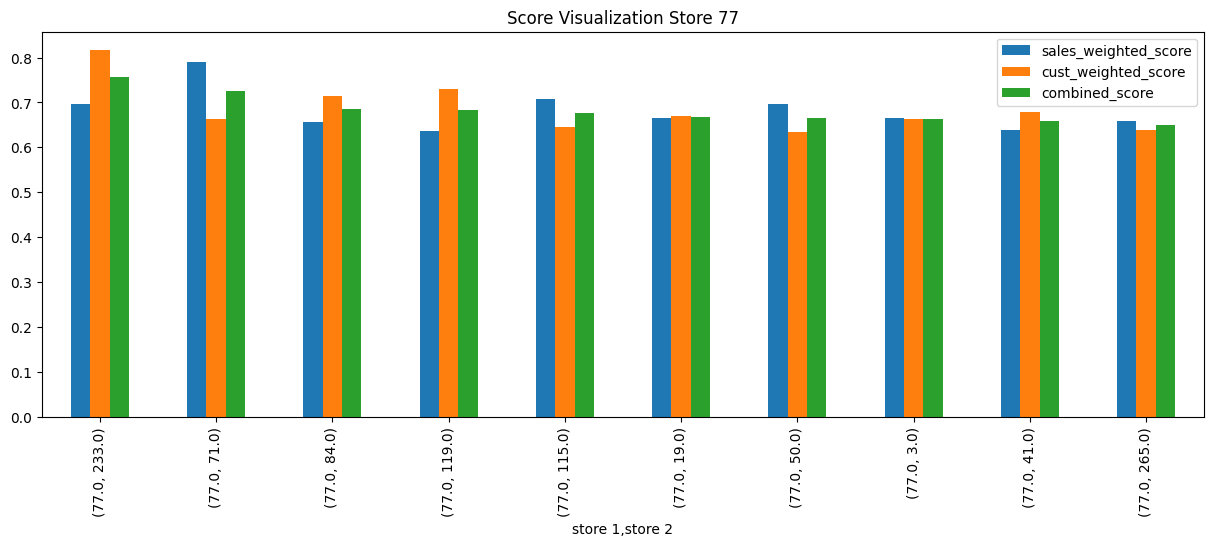

In [ ]:
combined_df.head(10).plot(kind='bar',figsize=(15,5))
plt.title('Score Visualization Store 77')
plt.show()

In [ ]:
def trial_control_labelling(trial,control,dataframe):

  df = dataframe.copy()

  control_store = control
  trial_store = trial

  store_type = []

  for i in df['store_number']:
    if i == trial_store:
        store_type.append('trial store')
    elif i == control_store:
        store_type.append('control store')
    else:
        store_type.append('other stores')

  df['store_type'] = store_type
  return df

In [ ]:
def metric_comparison(metric,data):

  other_metric = data.loc[data['store_type'] == 'other stores', ['year_month', metric]]
  other_metric_mean = other_metric.groupby('year_month').mean()
  other_metric_mean.rename(columns={metric: 'other stores'}, inplace=True)

  store_types = ['control store', 'trial store', 'other stores']

  metric_data = {}
  for store_type in store_types:
    if store_type == 'other stores':
        metrics = other_metric_mean
    else:
        metrics = data.loc[data['store_type'] == store_type, ['year_month', metric]]
        metrics.set_index('year_month', inplace=True)
        metrics.rename(columns={metric: store_type}, inplace=True)
    metric_data[store_type] = metrics

  control_store = metric_data['control store']
  trial_store = metric_data['trial store']
  other_stores = metric_data['other stores']

  metric_data = pd.concat([control_store, trial_store, other_stores], axis=1)
  return metric_data

**Hypothesis Testing of Pre Trial Period**

- Null Hypothesis : There is no difference in the monthly sales and monthly_uniq_cust between Stores 77 and 233.

- Alternative Hypothesis : There is a difference in the monthly sales and monthly_uniq_cust between Stores 77 and 233.

**Conducting a two sample t_test**

**Visualizing the pre_trial period**

In [ ]:
df1 = trial_control_labelling(77,233,pretrial_stats_df)

In [ ]:
df1['store_type'].value_counts()

other stores     1806
trial store         7
control store       7
Name: store_type, dtype: int64

**Monthly Sales**

In [ ]:
sales_data = metric_comparison('monthly_sales',df1)
sales_data

,control store,trial store,other stores
year_month,,,
2018-07,290.7,296.8,638.004651
2018-08,285.9,255.5,610.223450
2018-09,228.6,225.2,620.198450
2018-10,185.7,204.5,635.314729
2018-11,211.6,245.3,618.864341
2018-12,279.8,267.3,648.453876
2019-01,177.5,204.4,628.684496


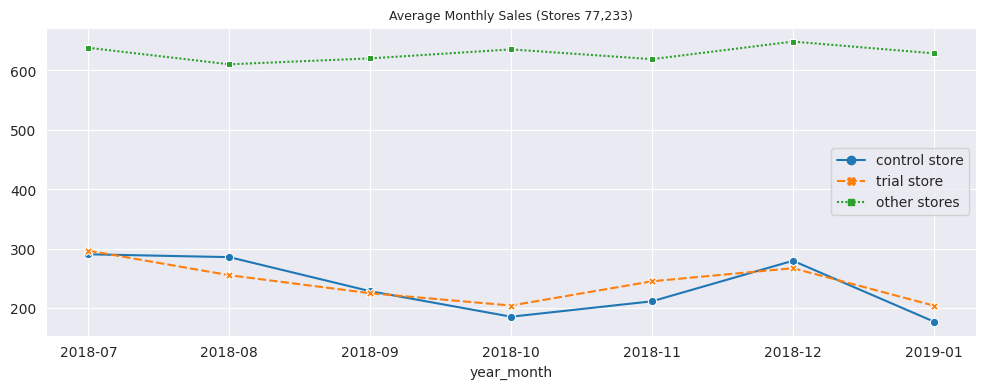

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,4))
sns.lineplot(data=sales_data,markers=True)
plt.title('Average Monthly Sales (Stores 77,233)',fontsize=9)
# plt.savefig('77,233,Sales')
plt.show()

In [ ]:
# Monthly Sales

ttest_ind(a=sales_data['control store'],b=sales_data['trial store'],equal_var=False)

TtestResult(statistic=-0.2508625111443089, pvalue=0.8066401079097753, df=10.774229275062746)

**No. of customers**

In [ ]:
customers_data = metric_comparison('monthly_uniq_cust',df1)
customers_data

,control store,trial store,other stores
year_month,,,
2018-07,51,51,72.333333
2018-08,48,47,72.120155
2018-09,42,42,70.131783
2018-10,35,37,71.608527
2018-11,40,41,70.534884
2018-12,47,46,73.515504
2019-01,35,35,71.240310


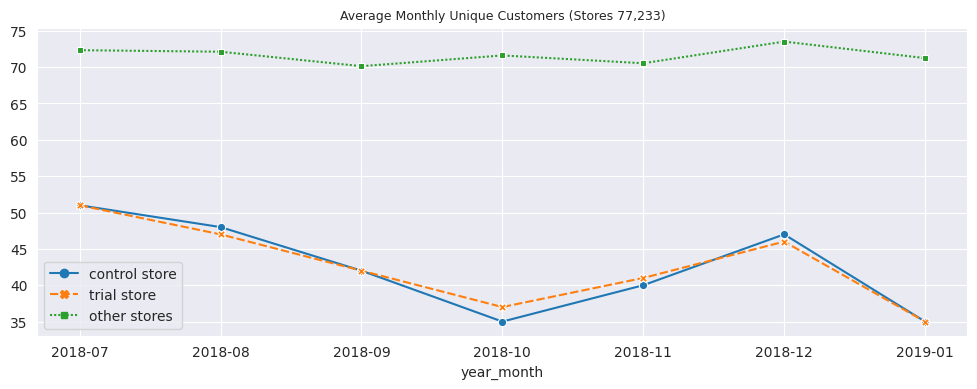

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,4))
sns.lineplot(data=customers_data,markers=True)
plt.title('Average Monthly Unique Customers (Stores 77,233)',fontsize=9)
# plt.savefig('77,233,customers')
plt.show()

In [ ]:
# sns.set_style('darkgrid')
# fig,ax = plt.subplots(2,1,figsize=(12,7),sharex=True)
# sns.lineplot(data=sales_data,markers=True,ax=ax[0])
# ax[0].set_title('Monthly Sales')
# sns.lineplot(data=customers_data,markers=True,ax=ax[1])
# ax[1].set_title('Monthly Unique Customers')
# plt.savefig('combined_77,233.png')
# plt.show()

In [ ]:
# Monthly Unique Customers
# Perfomring a Wwelch's t-test

ttest_ind(a=customers_data['control store'],b=customers_data['trial store'],equal_var=False)

TtestResult(statistic=-0.044382389011481414, pvalue=0.9653384704517609, df=11.85403796276974)

- The p_value is greater than out significance level of 0.05 meaning we do not have enough evidence to reject the null hypothesis.
- This means that there is no significant difference in both metrics between Stores 77 and 233

Findings:

- Both the statistical tests and visual comparisons appear to prove that indeed Store 233 is the most appropriate control store for Store 77.

**Assessment of the trial period**

We’ll start with scaling the control store’s sales to a level similar to control for any differences between the two stores outside of the trial period.

- As our null hypothesis is that the trial period is the same as the  pre‐trial period,
- let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

We'll define a function to help us in:
- Scaling the performance metrics of the control store to a similar period to the trial period.
- Calculate the percentage difference between the trial store performance metrics and the scaled control store metrics during the trial period.
- Perform a statistical test to prove whether or not the difference within the trial period is significant.

In [ ]:
def calc_tvalues(trial_store,control_store,metric,scaling_factor):

  full_stats_df = store_metrics(data).reset_index()

  if metric == 'monthly_sales':

    control_df = full_stats_df[full_stats_df['store_number'] == control_store]
    control_df['control_sales'] = control_df['monthly_sales'] * scaling_factor

    trial_store_sales = full_stats_df[full_stats_df['store_number'] == trial_store][['monthly_sales','year_month']]\
                      .rename(columns={'monthly_sales':'trial_store_sales'})

    global merged_sales
    merged_sales = control_df[['year_month','control_sales']].merge(trial_store_sales,on='year_month',how='inner')
    merged_sales['perc_diff'] =  abs(merged_sales['control_sales'] - merged_sales['trial_store_sales']) / merged_sales['control_sales']

    global std_dev_sales
    std_dev_sales = statistics.stdev(merged_sales.loc[merged_sales['year_month'] < '2019-02','perc_diff'])
    merged_sales['t_value'] = (merged_sales['perc_diff'] - 0) / std_dev_sales

    global t_values_sales
    t_values_sales = merged_sales.loc[(merged_sales['year_month'] < '2019-05') & (merged_sales['year_month'] > '2019-01'), ['year_month', 't_value']]
    return t_values_sales

  elif metric == 'monthly_uniq_cust':

    control_df = full_stats_df[full_stats_df['store_number'] == control_store]
    control_df['control_customers'] = control_df['monthly_uniq_cust'] * scaling_factor

    trial_store_customers = full_stats_df[full_stats_df['store_number'] == trial_store][['monthly_uniq_cust','year_month']]\
                      .rename(columns={'monthly_uniq_cust':'trial_store_customers'})

    global merged_customers
    merged_customers = control_df[['year_month','control_customers']].merge(trial_store_customers,on='year_month',how='inner')
    merged_customers['perc_diff'] =  abs(merged_customers['control_customers'] - merged_customers['trial_store_customers']) / merged_customers['control_customers']

    global std_dev_customers
    std_dev_customers = statistics.stdev(merged_customers.loc[merged_customers['year_month'] < '2019-02','perc_diff'])
    merged_customers['t_value'] = (merged_customers['perc_diff'] - 0) / std_dev_customers

    global t_values_customers
    t_values_customers = merged_customers.loc[(merged_customers['year_month'] < '2019-05') & (merged_customers['year_month'] > '2019-01'), ['year_month', 't_value']]

    return t_values_customers

  elif metric == 'txn_per_cust':

    control_df = full_stats_df[full_stats_df['store_number'] == control_store]
    control_df['control_txn_per_cust'] = control_df['txn_per_cust'] * scaling_factor

    trial_store_transactions = full_stats_df[full_stats_df['store_number'] == trial_store][['txn_per_cust','year_month']]\
                      .rename(columns={'txn_per_cust':'trial_store_transactions'})

    global merged_transactions
    merged_transactions = control_df[['year_month','control_txn_per_cust']].merge(trial_store_transactions,on='year_month',how='inner')
    merged_transactions['perc_diff'] =  abs(merged_transactions['control_txn_per_cust'] - merged_transactions['trial_store_transactions']) / merged_transactions['control_txn_per_cust']

    global std_dev_transactions
    std_dev_transactions = statistics.stdev(merged_transactions.loc[merged_transactions['year_month'] < '2019-02','perc_diff'])
    merged_transactions['t_value'] = (merged_transactions['perc_diff'] - 0) / std_dev_transactions

    global t_values_transactions
    t_values_transactions = merged_transactions.loc[(merged_transactions['year_month'] < '2019-05') & (merged_transactions['year_month'] > '2019-01'), ['year_month', 't_value']]
    return t_values_transactions

  elif metric == 'chips_per_txn':

    control_df = full_stats_df[full_stats_df['store_number'] == control_store]
    control_df['control_chips_per_txn'] = control_df['chips_per_txn'] * scaling_factor

    trial_store_chips = full_stats_df[full_stats_df['store_number'] == trial_store][['chips_per_txn','year_month']]\
                      .rename(columns={'chips_per_txn':'trial_store_chips'})

    global merged_chips
    merged_chips = control_df[['year_month','control_chips_per_txn']].merge(trial_store_chips,on='year_month',how='inner')
    merged_chips['perc_diff'] =  abs(merged_chips['control_chips_per_txn'] - merged_chips['trial_store_chips']) / merged_chips['control_chips_per_txn']

    global std_dev_chips
    std_dev_chips = statistics.stdev(merged_chips.loc[merged_chips['year_month'] < '2019-02','perc_diff'])
    merged_chips['t_value'] = (merged_chips['perc_diff'] - 0) / std_dev_chips

    global t_values_chips
    t_values_chips = merged_chips.loc[(merged_chips['year_month'] < '2019-05') & (merged_chips['year_month'] > '2019-01'), ['year_month', 't_value']]
    return t_values_chips

  elif metric == 'avg_price_per_unit':

    control_df = full_stats_df[full_stats_df['store_number'] == control_store]
    control_df['control_avg_price_per_unit'] = control_df['avg_price_per_unit'] * scaling_factor

    trial_store_price = full_stats_df[full_stats_df['store_number'] == trial_store][['avg_price_per_unit','year_month']]\
                      .rename(columns={'avg_price_per_unit':'trial_store_price'})

    global merged_price
    merged_price = control_df[['year_month','control_avg_price_per_unit']].merge(trial_store_price,on='year_month',how='inner')
    merged_price['perc_diff'] =  abs(merged_price['control_avg_price_per_unit'] - merged_price['trial_store_price']) / merged_price['control_avg_price_per_unit']

    global std_dev_price
    std_dev_price = statistics.stdev(merged_price.loc[merged_price['year_month'] < '2019-02','perc_diff'])
    merged_price['t_value'] = (merged_price['perc_diff'] - 0) / std_dev_price

    global t_values_price
    t_values_price = merged_price.loc[(merged_price['year_month'] < '2019-05') & (merged_price['year_month'] > '2019-01'), ['year_month', 't_value']]
    return t_values_price


**Monthly Sales**

In [ ]:
scaling_factor = df1[df1['store_type'] == 'trial store']['monthly_sales'].sum()/\
                  df1[df1['store_type'] == 'control store']['monthly_sales'].sum()
scaling_factor

1.023617303289553

In [ ]:
calc_tvalues(77,233,'monthly_sales',scaling_factor)

,year_month,t_value
7,2019-02,1.183534
8,2019-03,7.339116
9,2019-04,12.476373


In [ ]:
# note that there are 7 months in the pre‐trial period hence 7 ‐ 1 = 6 degrees of freedom
# calculate 95th percentile of t-distribution with appropriate degrees of freedom

degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 1.9431802803927816


In [ ]:
import scipy.stats as stats
degrees_of_freedom = 6

t_critical = stats.t.ppf(1-0.05/2, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 2.4469118487916806


We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store.

In [ ]:
# Calculating the 95th percentile value for sales for the control sales

sales_over_time = merged_sales[['year_month','control_sales','trial_store_sales']]
sales_over_time['control 95% confidence interval'] = sales_over_time ['control_sales'] * (1 + std_dev_sales * 2)
sales_over_time['control 5% confidence interval'] = sales_over_time ['control_sales'] * (1 - std_dev_sales * 2)
sales_over_time.set_index('year_month',inplace=True)

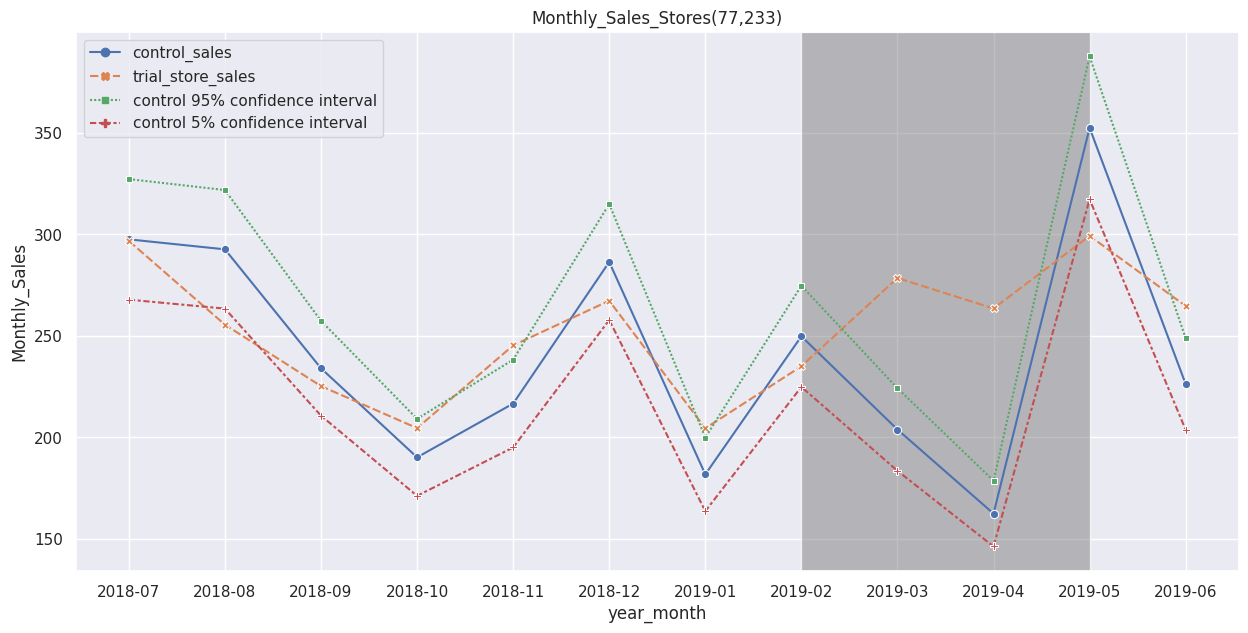

In [ ]:
sns.set(style='darkgrid')
plt.figure(figsize=(15,7))
sns.lineplot(sales_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Monthly_Sales')
# plt.savefig('Trial_Stores_Sales77,233')
plt.title('Monthly_Sales_Stores(77,233)')
plt.show()

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

**Monthly unique customers**

In [ ]:
scaling_factor = df1[df1['store_type'] == 'trial store']['monthly_uniq_cust'].sum()/df1[df1['store_type'] == 'control store']['monthly_uniq_cust'].sum()
scaling_factor

1.0033557046979866

In [ ]:
calc_tvalues(77,233,'monthly_uniq_cust',scaling_factor)

,year_month,t_value
7,2019-02,0.183352
8,2019-03,13.476388
9,2019-04,30.778725


In [ ]:
# note that there are 7 months in the pre‐trial period hence 7 ‐ 1 = 6 degrees of freedom
# calculate 95th percentile of t-distribution with appropriate degrees of freedom

degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 1.9431802803927816


Similarly, the number or unique customers are statistically significant during the months of March and April.

In [ ]:
customers_over_time = merged_customers[['year_month','control_customers','trial_store_customers']]
customers_over_time['control 95% confidence interval'] = customers_over_time ['control_customers'] * (1 + std_dev_customers * 2)
customers_over_time['control 5% confidence interval'] = customers_over_time ['control_customers'] * (1 - std_dev_customers * 2)
customers_over_time.set_index('year_month',inplace=True)

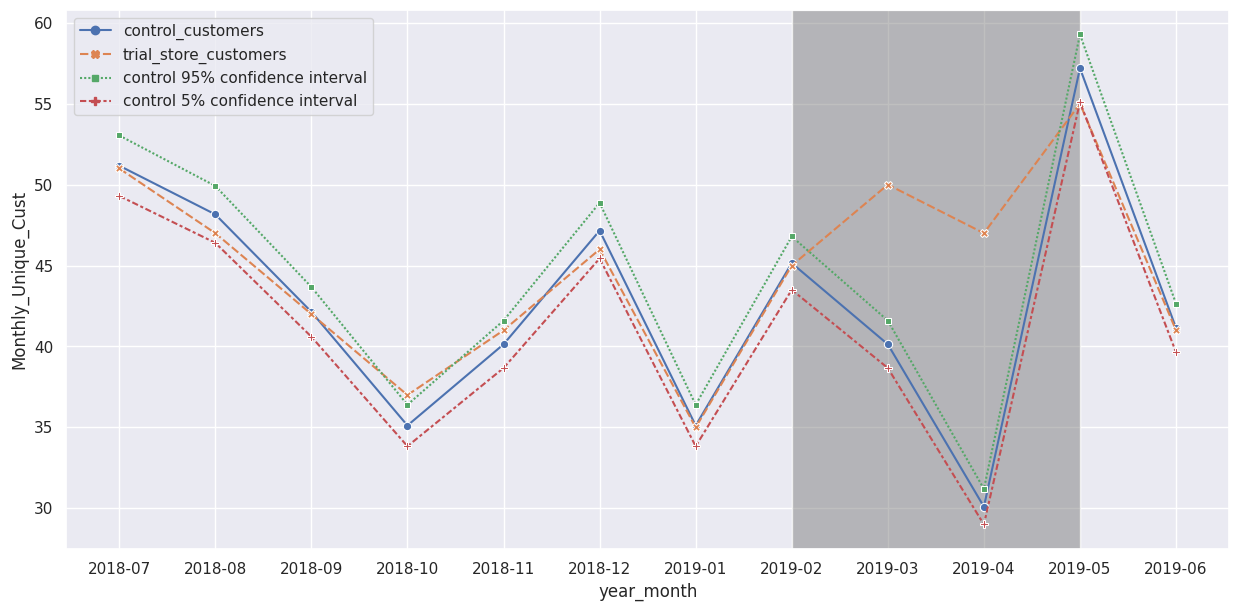

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(customers_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Monthly_Unique_Cust')
plt.savefig('Customers(77,233)')
# plt.title('Monthly_Unique_Customers(77,233)')
plt.show()

**Quantity of chip packets per transaction**

In [ ]:
scaling_factor_chips = df1[df1['store_type'] == 'trial store']['chips_per_txn'].sum()/\
                    df1[df1['store_type'] == 'control store']['chips_per_txn'].sum()
scaling_factor_chips

1.0020447732406148

In [ ]:
calc_tvalues(77,233,'chips_per_txn',scaling_factor_chips)

,year_month,t_value
7,2019-02,1.197043
8,2019-03,0.398818
9,2019-04,1.505535


In [ ]:
degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 1.9431802803927816


In [ ]:
chips_over_time = merged_chips[['year_month','control_chips_per_txn','trial_store_chips']]
chips_over_time['control 95% confidence interval'] = chips_over_time['control_chips_per_txn'] * (1 + std_dev_chips * 2)
chips_over_time['control 5% confidence interval'] = chips_over_time['control_chips_per_txn'] * (1 - std_dev_chips * 2)
chips_over_time.set_index('year_month',inplace=True)

In [ ]:
chips_over_time

,control_chips_per_txn,trial_store_chips,control 95% confidence interval,control 5% confidence interval
year_month,,,,
2018-07,1.632962,1.527273,1.910907,1.355017
2018-08,1.603272,1.541667,1.876163,1.330380
2018-09,1.558736,1.590909,1.824048,1.293425
2018-10,1.558736,1.368421,1.824048,1.293425
2018-11,1.515287,1.522727,1.773203,1.257371
2018-12,1.503067,1.500000,1.758903,1.247231
2019-01,1.345603,1.666667,1.574637,1.116569
2019-02,1.492407,1.644444,1.746429,1.238386
2019-03,1.441967,1.490909,1.687403,1.196531


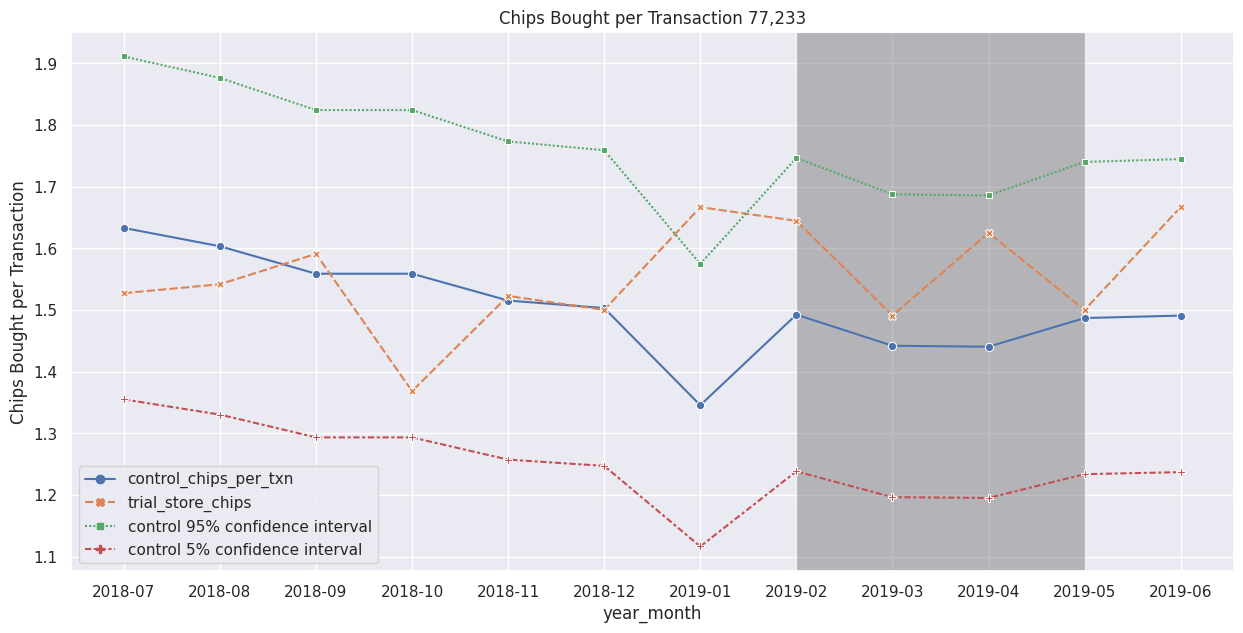

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(chips_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Chips Bought per Transaction')
plt.title('Chips Bought per Transaction 77,233')
plt.show()

**Transactions per Customer**

In [ ]:
scaling_factor_txn = df1[df1['store_type'] == 'trial store']['txn_per_cust'].sum()/\
                    df1[df1['store_type'] == 'control store']['txn_per_cust'].sum()
scaling_factor_txn

1.015909408114253

In [ ]:
calc_tvalues(77,233,'txn_per_cust',scaling_factor_txn)

,year_month,t_value
7,2019-02,1.953134
8,2019-03,1.913002
9,2019-04,1.953134


In [ ]:
degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 1.9431802803927816


In [ ]:
transactions_over_time = merged_transactions[['year_month','control_txn_per_cust','trial_store_transactions']]
transactions_over_time['control 95% confidence interval'] = transactions_over_time ['control_txn_per_cust'] * (1 + std_dev_transactions * 2)
transactions_over_time['control 5% confidence interval'] = transactions_over_time ['control_txn_per_cust'] * (1 - std_dev_transactions * 2)
transactions_over_time.set_index('year_month',inplace=True)

In [ ]:
transactions_over_time

,control_txn_per_cust,trial_store_transactions,control 95% confidence interval,control 5% confidence interval
year_month,,,,
2018-07,1.075669,1.078431,1.139056,1.012282
2018-08,1.058239,1.021277,1.120599,0.995879
2018-09,1.088474,1.047619,1.152616,1.024333
2018-10,1.044935,1.027027,1.106511,0.983360
2018-11,1.041307,1.073171,1.102669,0.979945
2018-12,1.080755,1.043478,1.144441,1.017068
2019-01,1.015909,1.114286,1.075775,0.956044
2019-02,1.061061,1.000000,1.123587,0.998535
2019-03,1.041307,1.100000,1.102669,0.979945


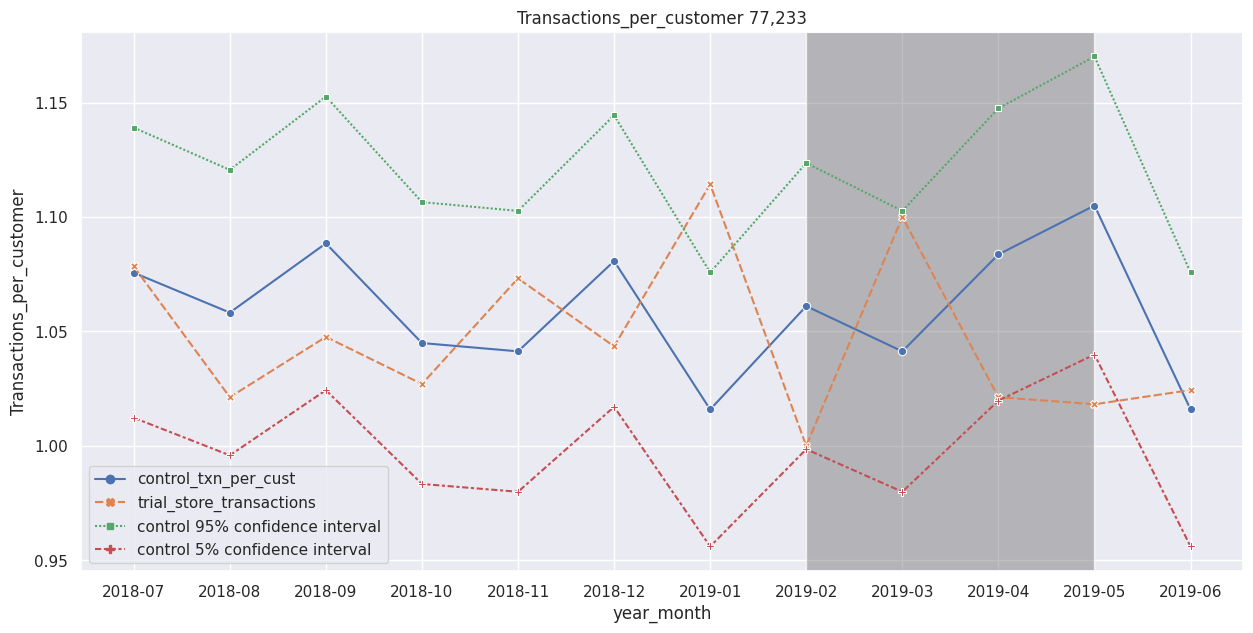

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(transactions_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Transactions_per_customer')
plt.title('Transactions_per_customer 77,233')
plt.show()

**Average price per chip unit**

In [ ]:
scaling_factor_price = df1[df1['store_type'] == 'trial store']['avg_price_per_unit'].sum()/\
                    df1[df1['store_type'] == 'control store']['avg_price_per_unit'].sum()
scaling_factor_price

1.0112830274771114

In [ ]:
calc_tvalues(77,233,'avg_price_per_unit',scaling_factor_price)

,year_month,t_value
7,2019-02,1.475338
8,2019-03,0.071145
9,2019-04,0.463315


In [ ]:
degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 1.9431802803927816


In [ ]:
price_over_time = merged_price[['year_month','control_avg_price_per_unit','trial_store_price']]
price_over_time['control 95% confidence interval'] = price_over_time ['control_avg_price_per_unit'] * (1 + std_dev_price * 2)
price_over_time['control 5% confidence interval'] = price_over_time ['control_avg_price_per_unit'] * (1 - std_dev_price * 2)
price_over_time.set_index('year_month',inplace=True)

In [ ]:
price_over_time

,control_avg_price_per_unit,trial_store_price,control 95% confidence interval,control 5% confidence interval
year_month,,,,
2018-07,3.340682,3.533333,3.789522,2.891841
2018-08,3.614073,3.452703,4.099645,3.128500
2018-09,3.302561,3.217143,3.746280,2.858842
2018-10,3.353487,3.932692,3.804048,2.902926
2018-11,3.451411,3.661194,3.915129,2.987693
2018-12,3.772760,3.712500,4.279653,3.265867
2019-01,3.819207,3.144615,4.332341,3.306074
2019-02,3.525044,3.175676,3.998655,3.051433
2019-03,3.412652,3.396341,3.871162,2.954141


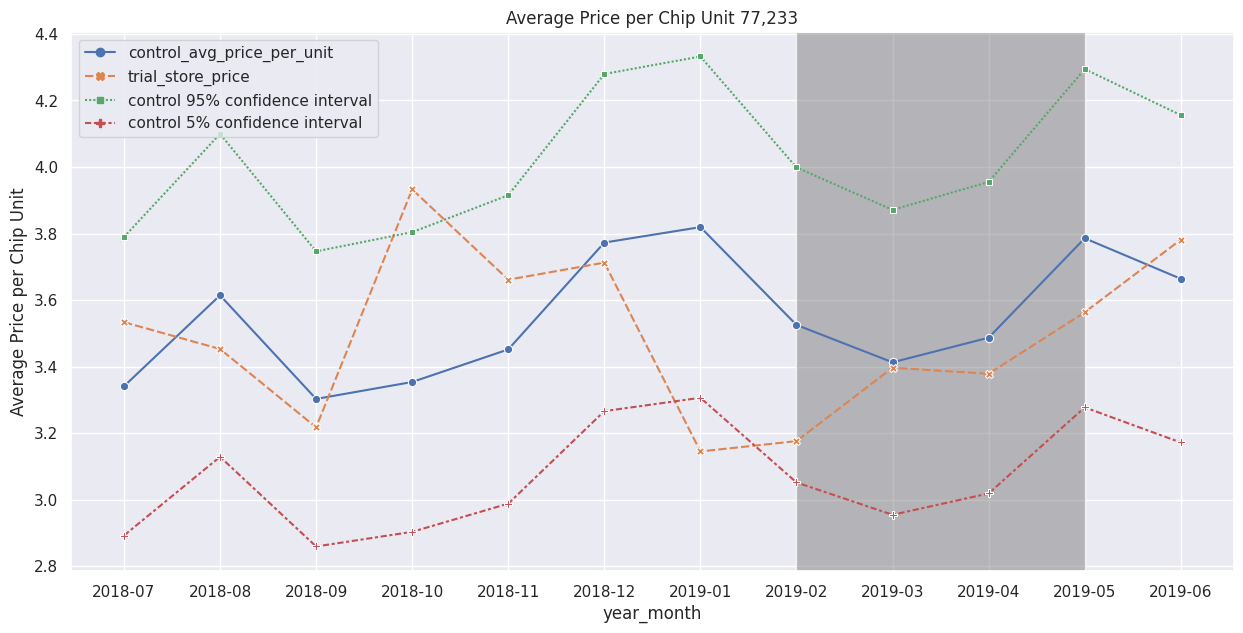

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(price_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Average Price per Chip Unit')
plt.title('Average Price per Chip Unit 77,233')
plt.show()

##**Store 86**

In [ ]:
sales_df = combine_metrics(pretrial_stats_df, 'monthly_sales', 86)
cust_df = combine_metrics(pretrial_stats_df,'monthly_uniq_cust', 86)
combined_df = concatenate_df(sales_df,cust_df)

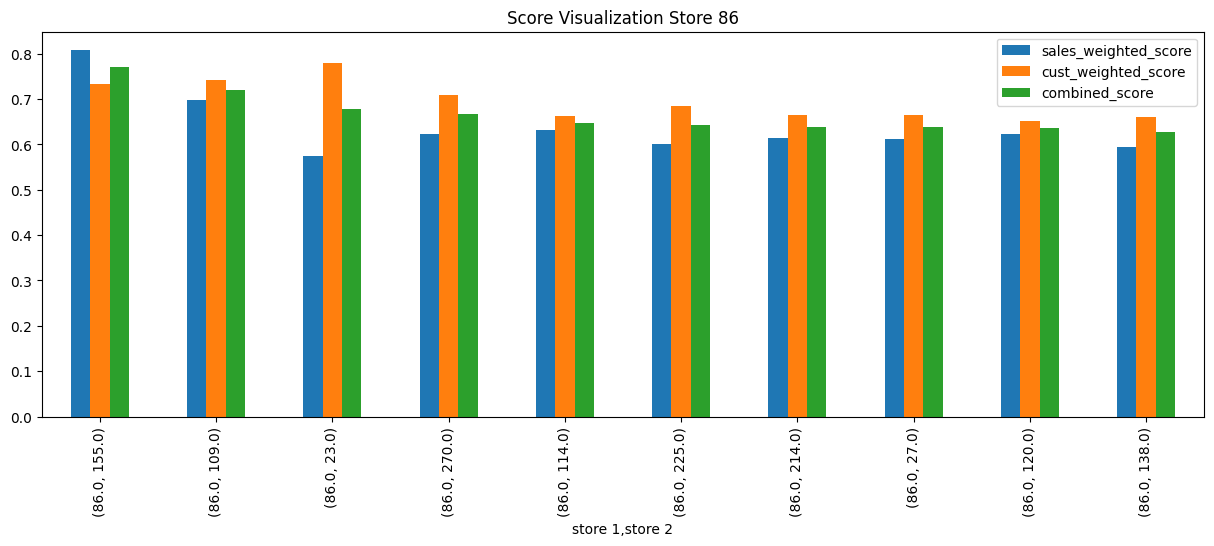

In [ ]:
combined_df.head(10).plot(kind='bar',figsize=(15,5))
plt.title('Score Visualization Store 86')
plt.show()

In [ ]:
df2 = trial_control_labelling(86,155,pretrial_stats_df)
df2.head()

,store_number,year_month,monthly_sales,monthly_uniq_cust,txn_per_cust,chips_per_txn,avg_price_per_unit,store_type
0,1,2018-07,206.9,49,1.061224,1.192308,3.337097,other stores
1,1,2018-08,176.1,42,1.023810,1.255814,3.261111,other stores
2,1,2018-09,278.8,59,1.050847,1.209677,3.717333,other stores
3,1,2018-10,188.1,44,1.022727,1.288889,3.243103,other stores
4,1,2018-11,192.6,46,1.021739,1.212766,3.378947,other stores


In [ ]:
df2['store_type'].value_counts()

other stores     1806
trial store         7
control store       7
Name: store_type, dtype: int64

In [ ]:
df2[df2['store_type'] == 'control store']

,store_number,year_month,monthly_sales,monthly_uniq_cust,txn_per_cust,chips_per_txn,avg_price_per_unit,store_type
1029,155,2018-07,924.6,101,1.217822,2.032520,3.698400,control store
1030,155,2018-08,782.7,91,1.307692,1.924370,3.417904,control store
1031,155,2018-09,1014.4,103,1.398058,2.013889,3.497931,control store
1032,155,2018-10,963.8,108,1.259259,2.000000,3.543382,control store
1033,155,2018-11,898.8,101,1.316832,2.030075,3.328889,control store
1034,155,2018-12,849.8,97,1.237113,2.016667,3.511570,control store
1035,155,2019-01,874.6,96,1.302083,2.016000,3.470635,control store


In [ ]:
sales_data = metric_comparison('monthly_sales',df2)
sales_data

,control store,trial store,other stores
year_month,,,
2018-07,924.6,892.20,633.239922
2018-08,782.7,764.05,606.326744
2018-09,1014.4,914.60,614.480620
2018-10,963.8,948.40,629.415504
2018-11,898.8,918.00,613.593411
2018-12,849.8,841.20,644.020155
2019-01,874.6,841.40,623.513566


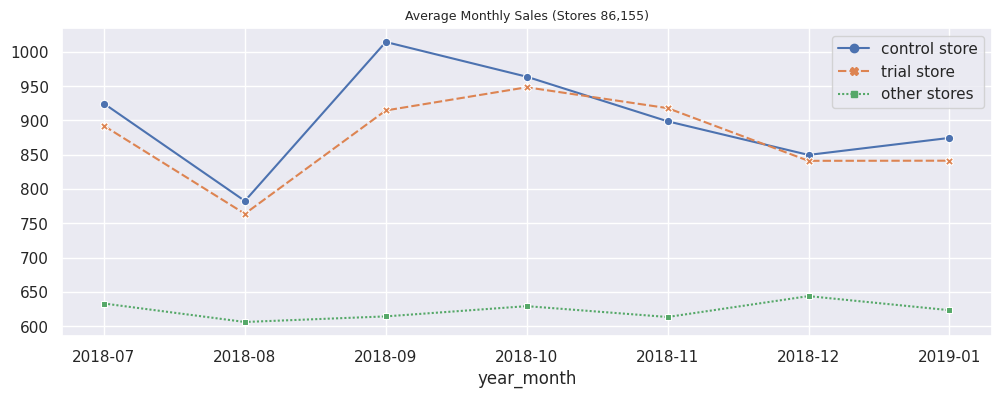

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,4))
sns.lineplot(data=sales_data,markers=True)
# plt.savefig('sales86,155')
plt.title('Average Monthly Sales (Stores 86,155)',fontsize=9)
plt.show()

In [ ]:
customers_data = metric_comparison('monthly_uniq_cust',df2)
customers_data

,control store,trial store,other stores
year_month,,,
2018-07,101,99,71.953488
2018-08,91,94,71.771318
2018-09,103,103,69.658915
2018-10,108,109,71.046512
2018-11,101,100,70.069767
2018-12,97,98,73.120155
2019-01,96,94,70.775194


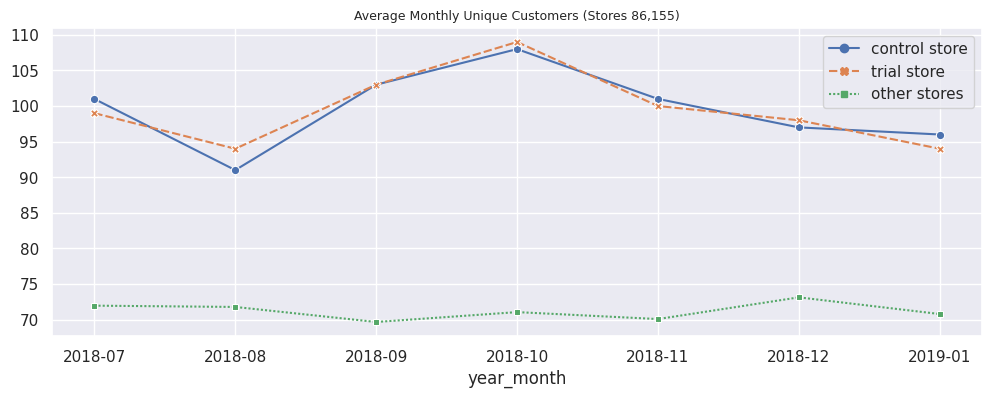

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,4))
sns.lineplot(data=customers_data,markers=True)
# plt.savefig('customers86,155')
plt.title('Average Monthly Unique Customers (Stores 86,155)',fontsize=9)
plt.show()

In [ ]:
# sns.set_style('darkgrid')
# fig,ax = plt.subplots(2,1,figsize=(12,7),sharex=True)
# sns.lineplot(data=sales_data,markers=True,ax=ax[0])
# ax[0].set_title('Monthly Sales')
# sns.lineplot(data=customers_data,markers=True,ax=ax[1])
# ax[1].set_title('Monthly Unique Customers')
# plt.savefig('combined_86,155.png')
# plt.show()

Findings:

A similar trend is observed in both metrics, further affirming Store 155 as the control store for Store 86.

**Hypothesis Testing of Pre Trial Period**

Null Hypothesis : There is no difference in the monthly sales and monthly_uniq_cust between Stores 77 and 233.

Alternative Hypothesis : There is a difference in the monthly sales and monthly_uniq_cust between Stores 77 and 233.

**Conducting a two sample t_test**

In [ ]:
# Monthly Sales

ttest_ind(a=sales_data['control store'],b=sales_data['trial store'],equal_var=False)

TtestResult(statistic=0.7237694965753882, pvalue=0.48356247094235816, df=11.588253089178133)

In [ ]:
# Monthly Unique Customers

ttest_ind(a=customers_data['control store'],b=customers_data['trial store'],equal_var=False)

TtestResult(statistic=0.0, pvalue=1.0, df=11.980320774382855)

- Both tests reveal that there is no significant difference in both metrics between the two stores.

**Assessment of the trial period**

We’ll start with scaling the control store’s sales to a level similar to control for any differences between the two stores outside of the trial period.

As our null hypothesis is that the trial period is the same as the pre‐trial period,
let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

**Monthly Sales**

In [ ]:
scaling_factor = df2[df2['store_type'] == 'trial store']['monthly_sales'].sum()/\
                  df2[df2['store_type'] == 'control store']['monthly_sales'].sum()
scaling_factor

0.9700651481287743

In [ ]:
calc_tvalues(86,155,'monthly_sales',scaling_factor)

,year_month,t_value
7,2019-02,2.179542
8,2019-03,12.226922
9,2019-04,1.364580


In [ ]:
degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 1.9431802803927816


- The monthly sales appear to be appear to statistically greater in the months of February and March as per the respective t_values.

In [ ]:
# Calculating the 95th percentile value for sales for the control sales

sales_over_time = merged_sales[['year_month','control_sales','trial_store_sales']]
sales_over_time['control 95% confidence interval'] = sales_over_time ['control_sales'] * (1 + std_dev_sales * 2)
sales_over_time['control 5% confidence interval'] = sales_over_time ['control_sales'] * (1 - std_dev_sales * 2)
sales_over_time.set_index('year_month',inplace=True)

In [ ]:
sales_over_time

,control_sales,trial_store_sales,control 95% confidence interval,control 5% confidence interval
year_month,,,,
2018-07,896.922236,892.20,943.264329,850.580142
2018-08,759.269991,764.05,798.499882,720.040101
2018-09,984.034086,914.60,1034.877067,933.191106
2018-10,934.948790,948.40,983.255636,886.641944
2018-11,871.894555,918.00,916.943521,826.845589
2018-12,824.361363,841.20,866.954388,781.768338
2019-01,848.418979,841.40,892.255010,804.582947
2019-02,864.522060,913.20,909.190104,819.854016
2019-03,780.320405,1026.80,820.637926,740.002884


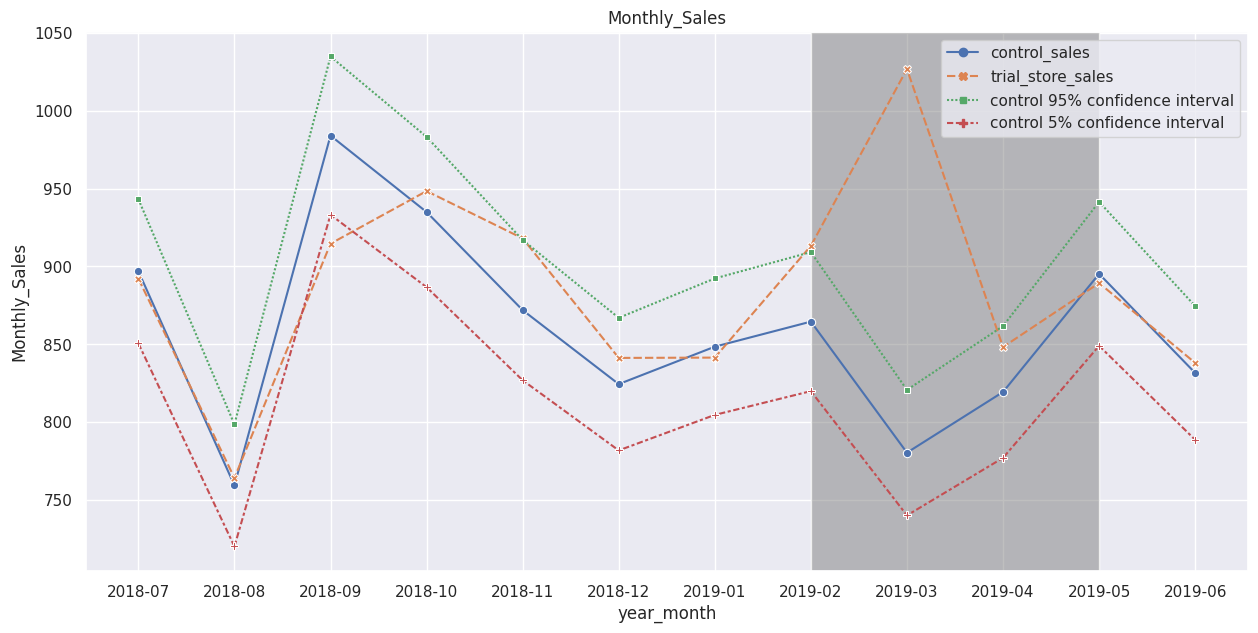

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(sales_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Monthly_Sales')
# plt.savefig('Trial_sales_86,155')
plt.title('Monthly_Sales')
plt.show()

- The visual confirms the difference in monthly sales as the trial store sales lie well outside the 95th percentile interval.

**Monthly unique customers**

In [ ]:
scaling_factor = df2[df2['store_type'] == 'trial store']['monthly_uniq_cust'].sum()/\
                  df2[df2['store_type'] == 'control store']['monthly_uniq_cust'].sum()
scaling_factor

1.0

In [ ]:
calc_tvalues(86,155,'monthly_uniq_cust',scaling_factor)

,year_month,t_value
7,2019-02,11.819082
8,2019-03,20.903430
9,2019-04,5.670772


In [ ]:
degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 1.9431802803927816


Unlike in monthly_sales, the number of unique customers per month significantly increased throughout the trial period.

In [ ]:
customers_over_time = merged_customers[['year_month','control_customers','trial_store_customers']]
customers_over_time['control 95% confidence interval'] = customers_over_time ['control_customers'] * (1 + std_dev_customers * 2)
customers_over_time['control 5% confidence interval'] = customers_over_time ['control_customers'] * (1 - std_dev_customers * 2)
customers_over_time.set_index('year_month',inplace=True)

In [ ]:
customers_over_time

,control_customers,trial_store_customers,control 95% confidence interval,control 5% confidence interval
year_month,,,,
2018-07,101.0,99,103.158864,98.841136
2018-08,91.0,94,92.945115,89.054885
2018-09,103.0,103,105.201614,100.798386
2018-10,108.0,109,110.308488,105.691512
2018-11,101.0,100,103.158864,98.841136
2018-12,97.0,98,99.073364,94.926636
2019-01,96.0,94,98.051989,93.948011
2019-02,95.0,107,97.030614,92.969386
2019-03,94.0,115,96.009240,91.990760


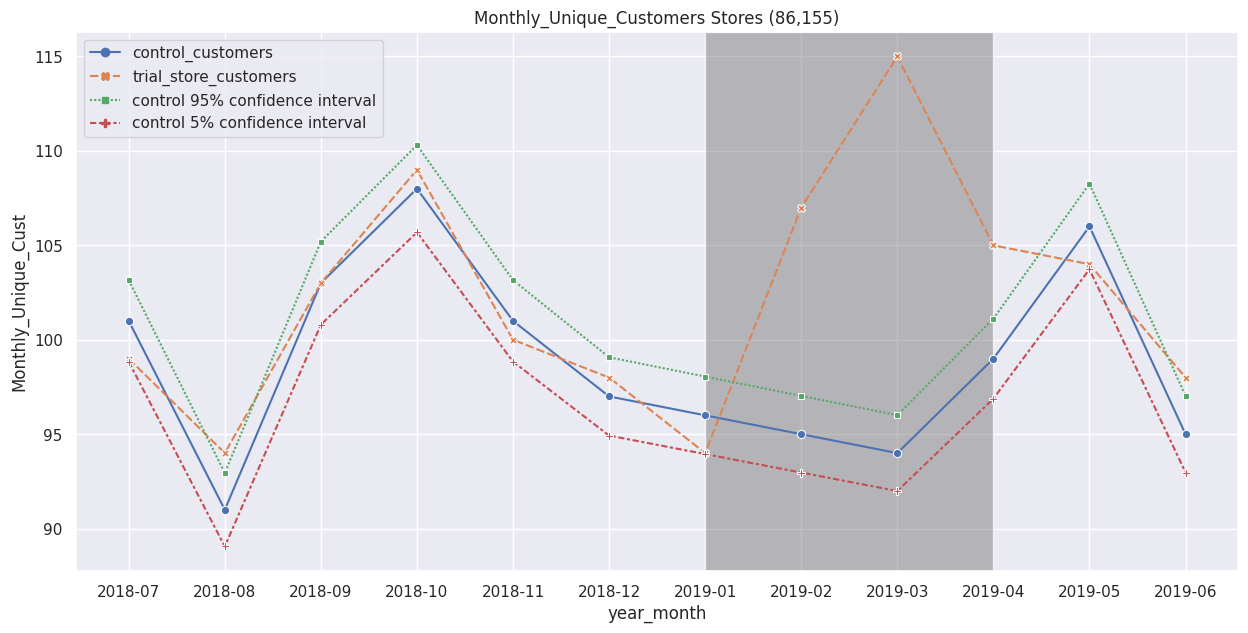

In [ ]:
sns.set(style='darkgrid')
plt.figure(figsize=(15,7))
sns.lineplot(customers_over_time,markers=True)
plt.axvspan('2019-01','2019-04', facecolor='grey', alpha=0.5)
plt.ylabel('Monthly_Unique_Cust')
# plt.savefig('customers,86,155')
plt.title('Monthly_Unique_Customers Stores (86,155)')
plt.show()

**Quantity of chip packets per transaction**

In [ ]:
scaling_factor_chips = df2[df2['store_type'] == 'trial store']['chips_per_txn'].sum()/\
                    df2[df2['store_type'] == 'control store']['chips_per_txn'].sum()
scaling_factor_chips

0.9983052724714834

In [ ]:
calc_tvalues(86,155,'chips_per_txn',scaling_factor_chips)

,year_month,t_value
7,2019-02,1.412227
8,2019-03,0.124471
9,2019-04,0.175220


In [ ]:
degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 1.9431802803927816


In [ ]:
chips_over_time = merged_chips[['year_month','control_chips_per_txn','trial_store_chips']]
chips_over_time['control 95% confidence interval'] = chips_over_time['control_chips_per_txn'] * (1 + std_dev_chips * 2)
chips_over_time['control 5% confidence interval'] = chips_over_time['control_chips_per_txn'] * (1 - std_dev_chips * 2)
chips_over_time.set_index('year_month',inplace=True)

In [ ]:
chips_over_time

,control_chips_per_txn,trial_store_chips,control 95% confidence interval,control 5% confidence interval
year_month,,,,
2018-07,2.029076,1.992063,2.059263,1.998889
2018-08,1.921108,1.954545,1.949689,1.892528
2018-09,2.010476,2.015625,2.040386,1.980566
2018-10,1.996611,2.000000,2.026314,1.966907
2018-11,2.026635,2.032000,2.056785,1.996484
2018-12,2.013249,2.000000,2.043200,1.983297
2019-01,2.012583,2.015504,2.042525,1.982642
2019-02,2.028556,2.007246,2.058736,1.998377
2019-03,2.030451,2.028571,2.060659,2.000244


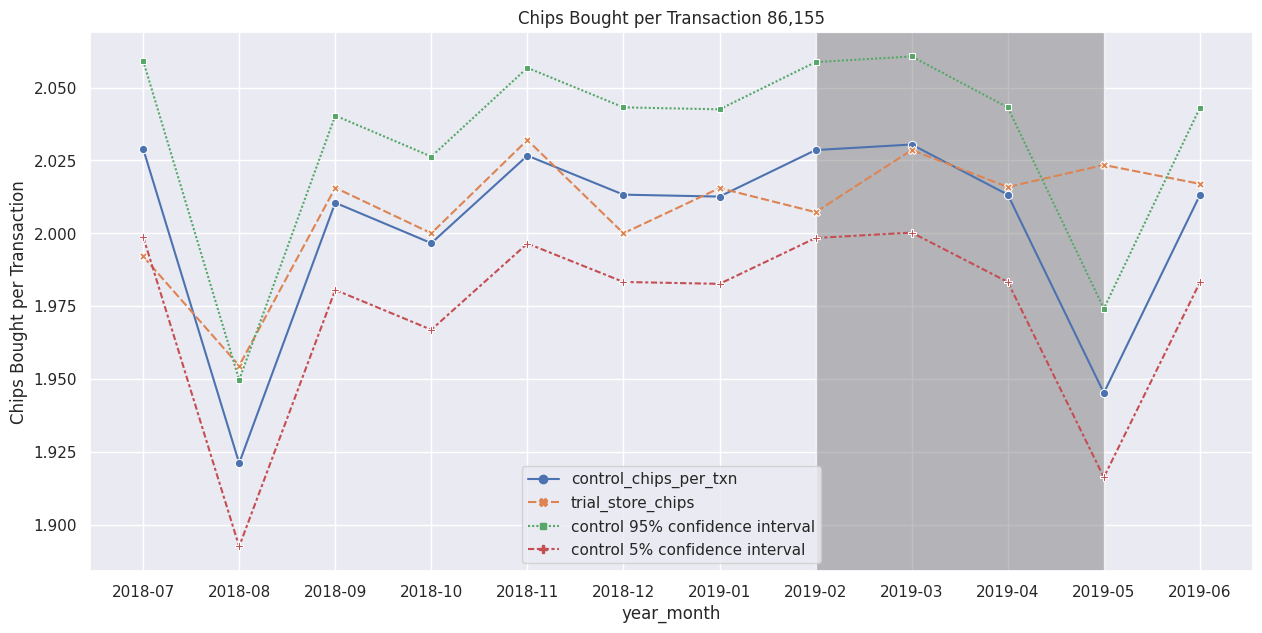

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(chips_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Chips Bought per Transaction')
plt.title('Chips Bought per Transaction 86,155')
plt.show()

**Transactions per Customer**

In [ ]:
scaling_factor_txn = df2[df2['store_type'] == 'trial store']['txn_per_cust'].sum()/\
                    df2[df2['store_type'] == 'control store']['txn_per_cust'].sum()
scaling_factor_txn


0.9734129893618191

In [ ]:
calc_tvalues(86,155,'txn_per_cust',scaling_factor_txn)

,year_month,t_value
7,2019-02,0.227335
8,2019-03,0.121713
9,2019-04,0.556666


In [ ]:
degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 1.9431802803927816


In [ ]:
transactions_over_time = merged_transactions[['year_month','control_txn_per_cust','trial_store_transactions']]
transactions_over_time['control 95% confidence interval'] = transactions_over_time ['control_txn_per_cust'] * (1 + std_dev_transactions * 2)
transactions_over_time['control 5% confidence interval'] = transactions_over_time ['control_txn_per_cust'] * (1 - std_dev_transactions * 2)
transactions_over_time.set_index('year_month',inplace=True)

In [ ]:
transactions_over_time

,control_txn_per_cust,trial_store_transactions,control 95% confidence interval,control 5% confidence interval
year_month,,,,
2018-07,1.185444,1.272727,1.258019,1.112869
2018-08,1.272925,1.170213,1.350855,1.194994
2018-09,1.360888,1.242718,1.444204,1.277572
2018-10,1.225779,1.266055,1.300824,1.150735
2018-11,1.281821,1.250000,1.360296,1.203346
2018-12,1.204222,1.224490,1.277947,1.130498
2019-01,1.267465,1.372340,1.345061,1.189868
2019-02,1.280807,1.289720,1.359220,1.202393
2019-03,1.221944,1.217391,1.296754,1.147134


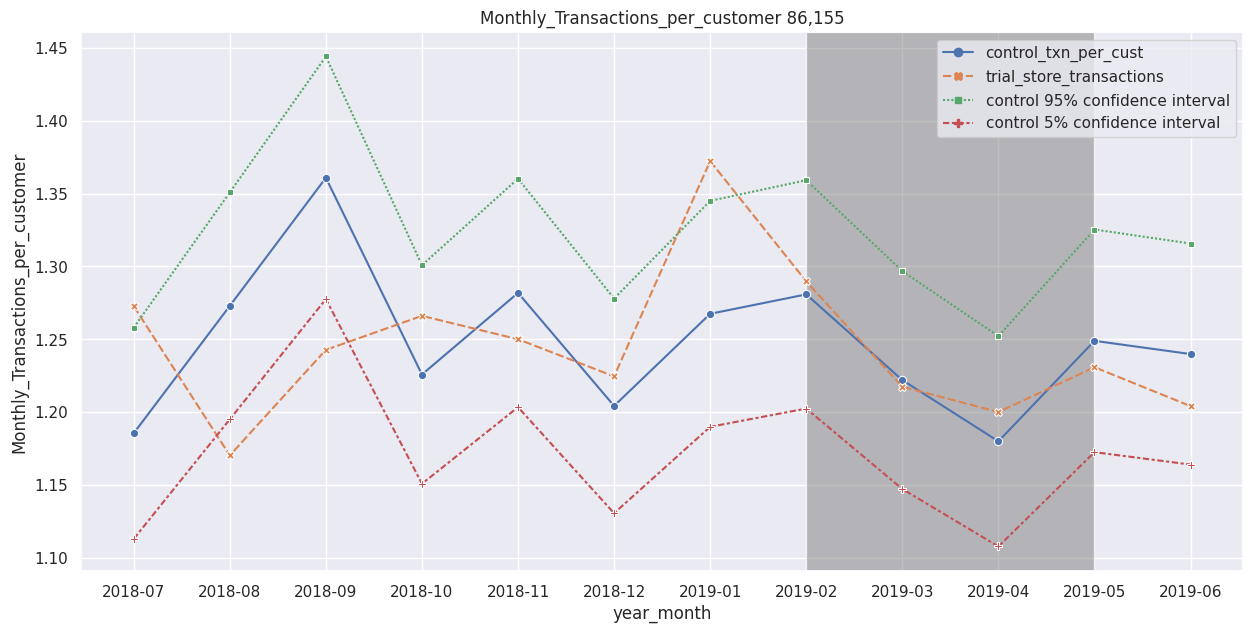

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(transactions_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Monthly_Transactions_per_customer')
plt.title('Monthly_Transactions_per_customer 86,155')
plt.show()

**Average price per chip unit**

In [ ]:
scaling_factor_price = df2[df2['store_type'] == 'trial store']['avg_price_per_unit'].sum()/\
                    df2[df2['store_type'] == 'control store']['avg_price_per_unit'].sum()
scaling_factor_price

0.9990237094124481

In [ ]:
calc_tvalues(86,155,'avg_price_per_unit',scaling_factor_price)

,year_month,t_value
7,2019-02,2.020879
8,2019-03,2.710300
9,2019-04,1.435454


In [ ]:
degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 1.9431802803927816


In [ ]:
price_over_time = merged_price[['year_month','control_avg_price_per_unit','trial_store_price']]
price_over_time['control 95% confidence interval'] = price_over_time ['control_avg_price_per_unit'] * (1 + std_dev_price * 2)
price_over_time['control 5% confidence interval'] = price_over_time ['control_avg_price_per_unit'] * (1 - std_dev_price * 2)
price_over_time.set_index('year_month',inplace=True)

In [ ]:
price_over_time

,control_avg_price_per_unit,trial_store_price,control 95% confidence interval,control 5% confidence interval
year_month,,,,
2018-07,3.694789,3.554582,3.912278,3.477300
2018-08,3.414567,3.553721,3.615561,3.213573
2018-09,3.494516,3.544961,3.700216,3.288816
2018-10,3.539923,3.436232,3.748296,3.331550
2018-11,3.325639,3.614173,3.521398,3.129880
2018-12,3.508142,3.505000,3.714644,3.301640
2019-01,3.467247,3.236154,3.671341,3.263152
2019-02,3.505236,3.296751,3.711567,3.298905
2019-03,3.348394,3.615493,3.545493,3.151296


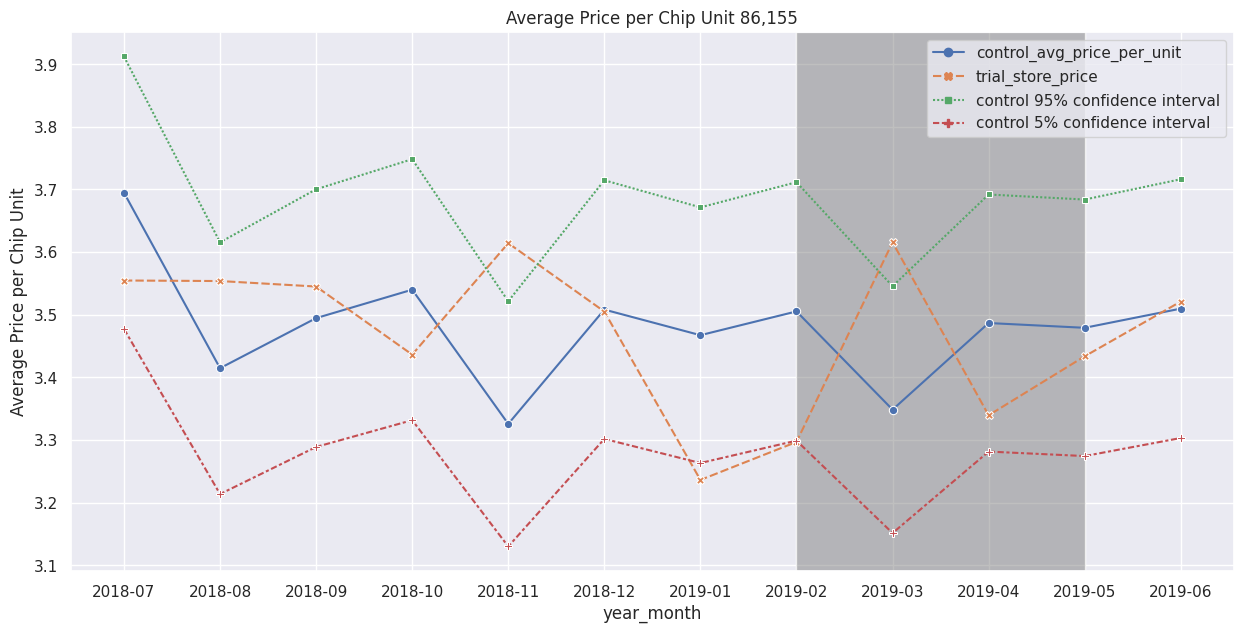

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(price_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Average Price per Chip Unit')
plt.title('Average Price per Chip Unit 86,155')
plt.show()

##**Store 88**

In [ ]:
sales_df = combine_metrics(pretrial_stats_df, 'monthly_sales', 88)
cust_df = combine_metrics(pretrial_stats_df,'monthly_uniq_cust', 88)
combined_df = concatenate_df(sales_df,cust_df)

In [ ]:
combined_df

sales_weighted_score  cust_weighted_score  combined_score
store 1 store 2                                                           
88.0    178.0                0.650803             0.707828        0.679316
        14.0                 0.646064             0.685774        0.665919
        134.0                0.775084             0.540154        0.657619
        133.0                0.615596             0.659949        0.637773
        237.0                0.451974             0.777235        0.614604
...                               ...                  ...             ...
        170.0                0.175916             0.300006        0.237961
        108.0                0.269125             0.202555        0.235840
        114.0                0.272404             0.194117        0.233261
        177.0                0.282032             0.157546        0.219789
        88.0                      NaN                  NaN             NaN

[260 rows x 3 columns]

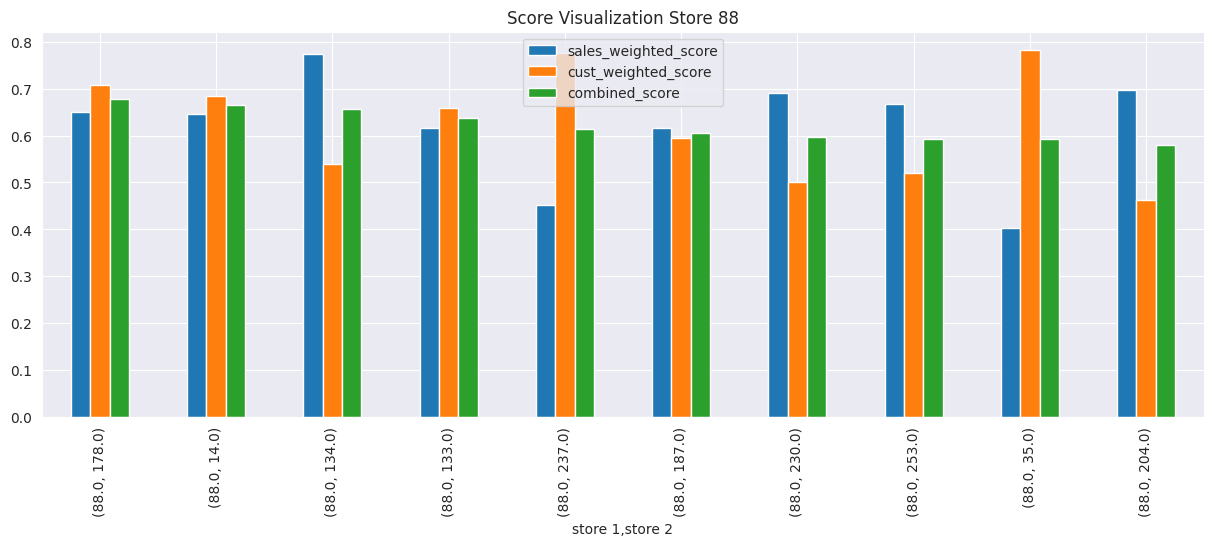

In [ ]:
combined_df.head(10).plot(kind='bar',figsize=(15,5))
plt.title('Score Visualization Store 88')
plt.show()

**Hypothesis testing to affirm our control store decision**

- Null Hypothesis: There is no difference in either metrics between the two stores.
- Alternative hypothesis: There is a significant difference between the means of the two stores.
- Significance level : 0.5

In [ ]:
ttest_res = []
metrics = ['monthly_sales','monthly_uniq_cust']
for i in metrics:

  ttest_res.append(ttest_ind(a=pretrial_stats_df.set_index('store_number').loc[88][i],\
          b=pretrial_stats_df.set_index('store_number').loc[178][i],equal_var=False))

res_df = pd.DataFrame(ttest_res,index=metrics)
res_df

,statistic,pvalue
monthly_sales,15.477665,2.991409e-09
monthly_uniq_cust,8.032778,3.850449e-06


In [ ]:
ttest_res = []
metrics = ['monthly_sales','monthly_uniq_cust']
for i in metrics:

  ttest_res.append(ttest_ind(a=pretrial_stats_df.set_index('store_number').loc[88][i],\
          b=pretrial_stats_df.set_index('store_number').loc[14][i],equal_var=False))

res_df = pd.DataFrame(ttest_res,index=metrics)
res_df

,statistic,pvalue
monthly_sales,65.796927,1.713097e-10
monthly_uniq_cust,60.451715,1.701923e-11


In [ ]:
ttest_res = []
metrics = ['monthly_sales','monthly_uniq_cust']
for i in metrics:

  ttest_res.append(ttest_ind(a=pretrial_stats_df.set_index('store_number').loc[88][i],\
          b=pretrial_stats_df.set_index('store_number').loc[178][i],equal_var=False))

res_df = pd.DataFrame(ttest_res,index=metrics)
res_df

In [ ]:
ttest_res = []
metrics = ['monthly_sales','monthly_uniq_cust']
for i in metrics:

  ttest_res.append(ttest_ind(a=pretrial_stats_df.set_index('store_number').loc[88][i],\
          b=pretrial_stats_df.set_index('store_number').loc[134][i],equal_var=False))

res_df = pd.DataFrame(ttest_res,index=metrics)
res_df

,statistic,pvalue
monthly_sales,39.215698,1.440388e-12
monthly_uniq_cust,32.536917,8.834290e-13


In [ ]:
ttest_res = []
metrics = ['monthly_sales','monthly_uniq_cust']
for i in metrics:

  ttest_res.append(ttest_ind(a=pretrial_stats_df.set_index('store_number').loc[88][i],\
          b=pretrial_stats_df.set_index('store_number').loc[133][i],equal_var=False))

res_df = pd.DataFrame(ttest_res,index=metrics)
res_df

,statistic,pvalue
monthly_sales,10.442592,5.524510e-07
monthly_uniq_cust,5.452866,1.476641e-04


In [ ]:
ttest_res = []
metrics = ['monthly_sales','monthly_uniq_cust']
for i in metrics:

  ttest_res.append(ttest_ind(a=pretrial_stats_df.set_index('store_number').loc[88][i],\
          b=pretrial_stats_df.set_index('store_number').loc[237][i],equal_var=False))

res_df = pd.DataFrame(ttest_res,index=metrics)
res_df

,statistic,pvalue
monthly_sales,0.059288,0.953850
monthly_uniq_cust,-0.244949,0.810793


Despite Store 178 having the highest combined correlation and magnitude score, the results of the t-test prove otherwise.
The p_values are below our siginificance level hence they reject our null hypothesis.
The test between Stores 88 and 237 however generate p_values above our significance level, failing to reject the null hypothesis.
This makes Store 237 the ideal control store for Store 88.

In [ ]:
df3 = trial_control_labelling(88,237,pretrial_stats_df)
df3.head()

,store_number,year_month,monthly_sales,monthly_uniq_cust,txn_per_cust,chips_per_txn,avg_price_per_unit,store_type
0,1,2018-07,206.9,49,1.061224,1.192308,3.337097,other stores
1,1,2018-08,176.1,42,1.023810,1.255814,3.261111,other stores
2,1,2018-09,278.8,59,1.050847,1.209677,3.717333,other stores
3,1,2018-10,188.1,44,1.022727,1.288889,3.243103,other stores
4,1,2018-11,192.6,46,1.021739,1.212766,3.378947,other stores


In [ ]:
df3['store_type'].value_counts()

other stores     1806
trial store         7
control store       7
Name: store_type, dtype: int64

In [ ]:
df3[df3['store_type'] == 'control store']

,store_number,year_month,monthly_sales,monthly_uniq_cust,txn_per_cust,chips_per_txn,avg_price_per_unit,store_type
1575,237,2018-07,1448.4,128,1.265625,2.000000,4.470370,control store
1576,237,2018-08,1367.8,135,1.222222,1.896970,4.369968,control store
1577,237,2018-09,1322.2,126,1.182540,2.006711,4.422074,control store
1578,237,2018-10,1348.3,123,1.195122,2.034014,4.509365,control store
1579,237,2018-11,1397.6,132,1.219697,1.987578,4.367500,control store
1580,237,2018-12,1265.0,124,1.161290,2.006944,4.377163,control store
1581,237,2019-01,1219.7,117,1.188034,1.992806,4.403249,control store


**Monthly Sales**

In [ ]:
sales_data = metric_comparison('monthly_sales',df3)
sales_data

,control store,trial store,other stores
year_month,,,
2018-07,1448.4,1310.0,629.590310
2018-08,1367.8,1323.8,601.889341
2018-09,1322.2,1423.0,611.317054
2018-10,1348.3,1352.4,626.359302
2018-11,1397.6,1382.8,609.858527
2018-12,1265.0,1325.2,640.534884
2019-01,1219.7,1266.4,620.528682


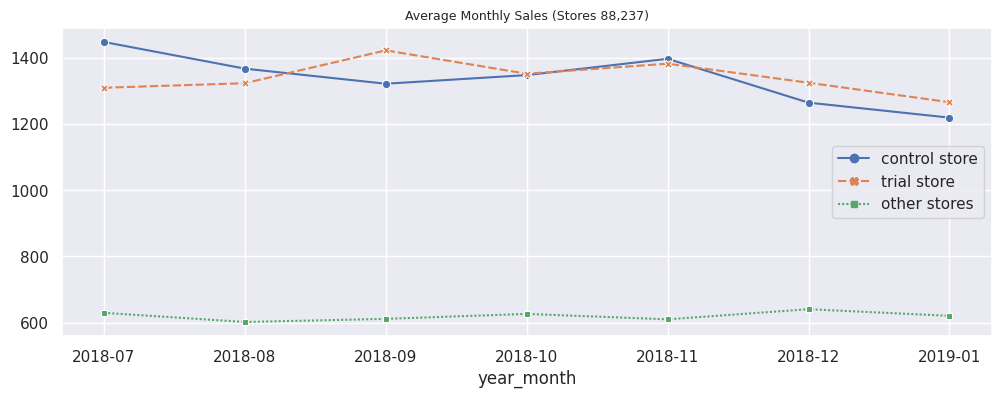

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,4))
sns.lineplot(data=sales_data,markers=True)
# plt.savefig('Sales(88,237)')
plt.title('Average Monthly Sales (Stores 88,237)',fontsize=9)
plt.show()

**Monthly unique customers**

In [ ]:
customers_data = metric_comparison('monthly_uniq_cust',df3)
customers_data

,control store,trial store,other stores
year_month,,,
2018-07,128,129,71.732558
2018-08,135,131,71.457364
2018-09,126,124,69.488372
2018-10,123,123,70.934109
2018-11,132,130,69.833333
2018-12,124,126,72.906977
2019-01,117,117,70.604651


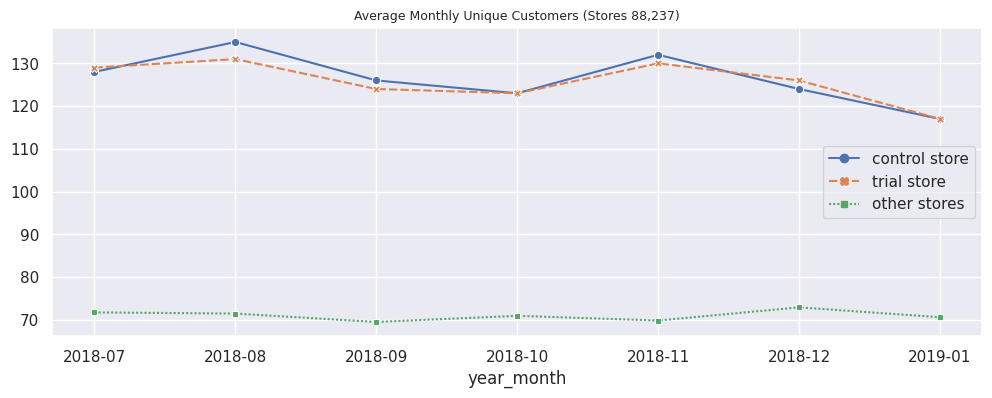

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,4))
sns.lineplot(data=customers_data,markers=True)
# plt.savefig('Customers(88,237)')
plt.title('Average Monthly Unique Customers (Stores 88,237)',fontsize=9)
plt.show()

- A similar trend is observed in our trial and control store in both metrics.

In [ ]:
# sns.set_style('darkgrid')
# fig,ax = plt.subplots(2,1,figsize=(12,7),sharex=True)
# sns.lineplot(data=sales_data,markers=True,ax=ax[0])
# ax[0].set_title('Monthly Sales')
# sns.lineplot(data=customers_data,markers=True,ax=ax[1])
# ax[1].set_title('Monthly Unique Customers')
# plt.savefig('combined_88,237.png')
# plt.show()

**Assessment of the trial period**

We’ll start with scaling the control store’s sales to a level similar to control for any differences between the two stores outside of the trial period.

As our null hypothesis is that the trial period is the same as the pre‐trial period,
let's take the standard deviation based on the scaled percentage difference in the pre‐trial period

**Monthly sales**

In [ ]:
scaling_factor = df3[df3['store_type'] == 'trial store']['monthly_sales'].sum()/\
                  df3[df3['store_type'] == 'control store']['monthly_sales'].sum()
scaling_factor

1.001558330664959

In [ ]:
calc_tvalues(88,237,'monthly_sales',scaling_factor)

,year_month,t_value
7,2019-02,0.781270
8,2019-03,6.595668
9,2019-04,5.768527


In [ ]:
degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 1.9431802803927816


- A significant increase is observed in the months of March and April

In [ ]:
# Calculating the 95th percentile value for sales for the control sales

sales_over_time = merged_sales[['year_month','control_sales','trial_store_sales']]
sales_over_time['control 95% confidence interval'] = sales_over_time ['control_sales'] * (1 + std_dev_sales * 2)
sales_over_time['control 5% confidence interval'] = sales_over_time ['control_sales'] * (1 - std_dev_sales * 2)
sales_over_time.set_index('year_month',inplace=True)

In [ ]:
sales_over_time

,control_sales,trial_store_sales,control 95% confidence interval,control 5% confidence interval
year_month,,,,
2018-07,1450.657086,1310.00,1547.757884,1353.556288
2018-08,1369.931485,1323.80,1461.628855,1278.234114
2018-09,1324.260425,1423.00,1412.900769,1235.620080
2018-10,1350.401097,1352.40,1440.791187,1260.011008
2018-11,1399.777923,1382.80,1493.473086,1306.082759
2018-12,1266.971288,1325.20,1351.776942,1182.165634
2019-01,1221.600696,1266.40,1303.369436,1139.831956
2019-02,1406.989143,1370.20,1501.166995,1312.811291
2019-03,1210.082775,1477.20,1291.080555,1129.084996


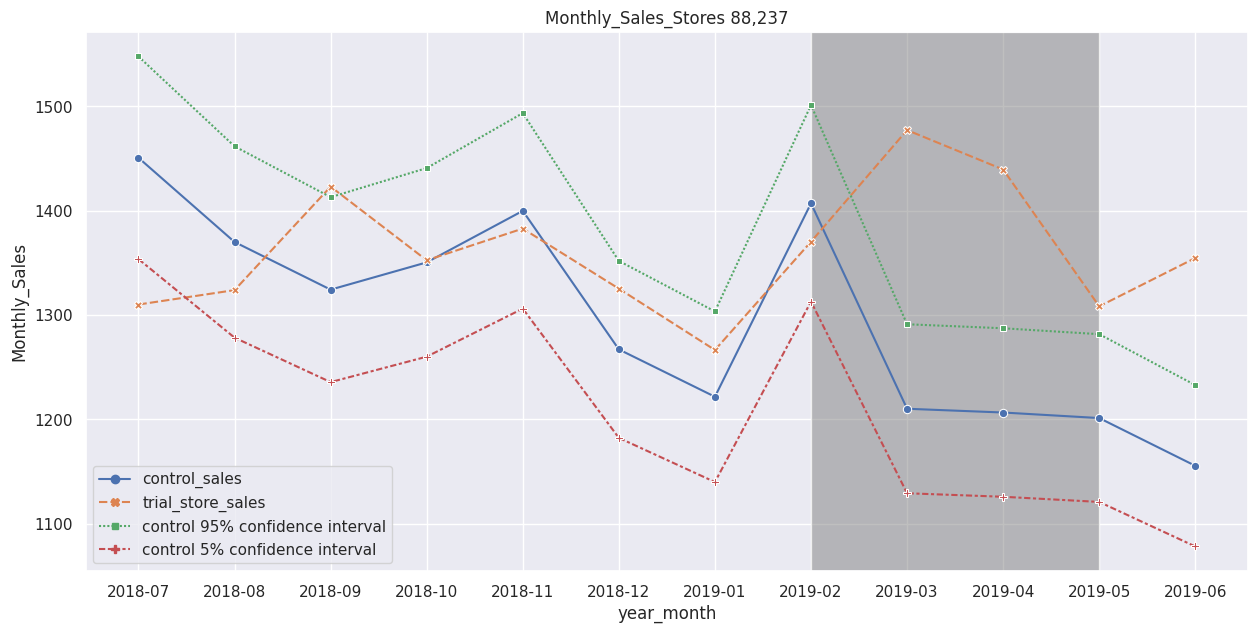

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(sales_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Monthly_Sales')
# plt.savefig('Trial sales (88,237)')
plt.title('Monthly_Sales_Stores 88,237')
plt.show()

- The visualization confirms it whereby the trial store's sales lie outside the 95th percentile interval.

**Monthly Unique Customers**

In [ ]:
scaling_factor = df3[df3['store_type'] == 'trial store']['monthly_uniq_cust'].sum()/\
                    df3[df3['store_type'] == 'control store']['monthly_uniq_cust'].sum()
scaling_factor

0.9943502824858758

In [ ]:
calc_tvalues(88,237,'monthly_uniq_cust',scaling_factor)

,year_month,t_value
7,2019-02,1.387456
8,2019-03,17.873693
9,2019-04,9.814423


In [ ]:
degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 1.9431802803927816


- A similar trend as in the monthly sales with a statistical increase in the months of March and April.

In [ ]:
customers_over_time = merged_customers[['year_month','control_customers','trial_store_customers']]
customers_over_time['control 95% confidence interval'] = customers_over_time ['control_customers'] * (1 + std_dev_customers * 2)
customers_over_time['control 5% confidence interval'] = customers_over_time ['control_customers'] * (1 - std_dev_customers * 2)
customers_over_time.set_index('year_month',inplace=True)

In [ ]:
customers_over_time

,control_customers,trial_store_customers,control 95% confidence interval,control 5% confidence interval
year_month,,,,
2018-07,127.276836,129,129.163141,125.390531
2018-08,134.237288,131,136.226750,132.247826
2018-09,125.288136,124,127.144967,123.431304
2018-10,122.305085,123,124.117706,120.492464
2018-11,131.254237,130,133.199489,129.308985
2018-12,123.299435,126,125.126793,121.472077
2019-01,116.338983,117,118.063184,114.614782
2019-02,125.288136,124,127.144967,123.431304
2019-03,118.327684,134,120.081358,116.574010


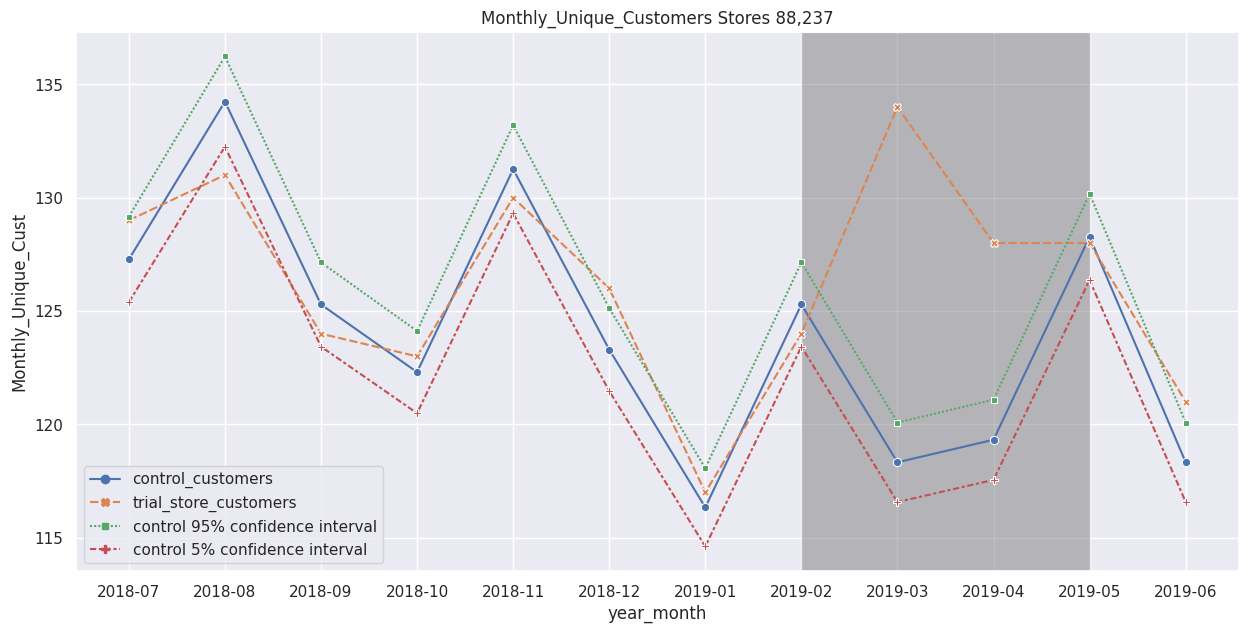

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(customers_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Monthly_Unique_Cust')
# plt.savefig('Trial Customers(88,237)')
plt.title('Monthly_Unique_Customers Stores 88,237')
plt.show()

Similarly, the trial store's distribution lies outside the 95th percentile interval in the months of February and March as well as April.

**Transacations per customer**

In [ ]:
scaling_factor_txn = df3[df3['store_type'] == 'trial store']['txn_per_cust'].sum()/\
                    df3[df3['store_type'] == 'control store']['txn_per_cust'].sum()
scaling_factor_txn

1.0105858988301917

In [ ]:
calc_tvalues(88,237,'txn_per_cust',scaling_factor_txn)

,year_month,t_value
7,2019-02,0.827547
8,2019-03,4.451017
9,2019-04,4.653756


In [ ]:
degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 1.9431802803927816


In [ ]:
transactions_over_time = merged_transactions[['year_month','control_txn_per_cust','trial_store_transactions']]
transactions_over_time['control 95% confidence interval'] = transactions_over_time ['control_txn_per_cust'] * (1 + std_dev_transactions * 2)
transactions_over_time['control 5% confidence interval'] = transactions_over_time ['control_txn_per_cust'] * (1 - std_dev_transactions * 2)
transactions_over_time.set_index('year_month',inplace=True)

In [ ]:
transactions_over_time

,control_txn_per_cust,trial_store_transactions,control 95% confidence interval,control 5% confidence interval
year_month,,,,
2018-07,1.279023,1.186047,1.341254,1.216791
2018-08,1.235161,1.206107,1.295258,1.175063
2018-09,1.195058,1.266129,1.253204,1.136912
2018-10,1.207773,1.260163,1.266538,1.149008
2018-11,1.232609,1.200000,1.292582,1.172635
2018-12,1.173584,1.174603,1.230685,1.116482
2019-01,1.200611,1.230769,1.259027,1.142194
2019-02,1.259222,1.233871,1.320490,1.197954
2019-03,1.137971,1.261194,1.193339,1.082602


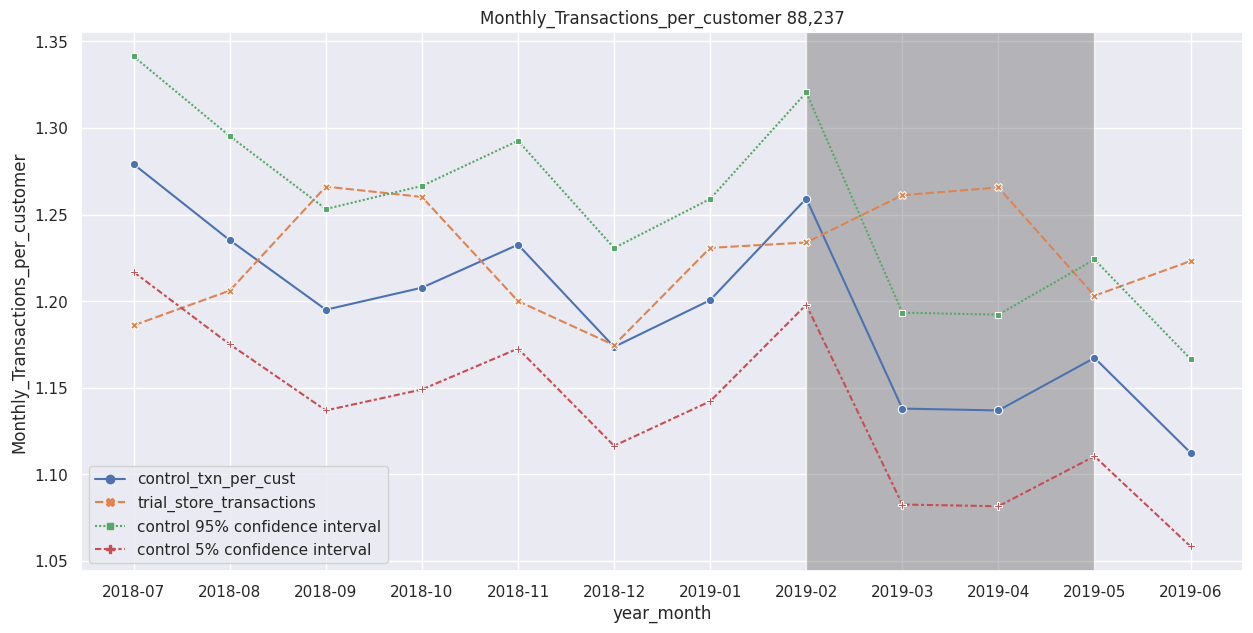

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(transactions_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Monthly_Transactions_per_customer')
# plt.savefig('Trial_transactions(88,237)')
plt.title('Monthly_Transactions_per_customer 88,237')
plt.show()

**Quantity of chips bought per transaction**

In [ ]:
scaling_factor_chips = df3[df3['store_type'] == 'trial store']['chips_per_txn'].sum()/\
                    df3[df3['store_type'] == 'control store']['chips_per_txn'].sum()
scaling_factor_chips

1.0079711293619547

In [ ]:
calc_tvalues(88,237,'chips_per_txn',scaling_factor_chips)

,year_month,t_value
7,2019-02,0.512499
8,2019-03,8.599373
9,2019-04,5.472176


In [ ]:
degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 1.9431802803927816


In [ ]:
merged_chips.head(3)

,year_month,control_chips_per_txn,trial_store_chips,perc_diff,t_value
0,2018-07,2.015942,2.000000,0.007908,2.846464
1,2018-08,1.912091,1.917722,0.002945,1.059981
2,2018-09,2.022707,2.025478,0.001370,0.493021


In [ ]:
chips_over_time = merged_chips[['year_month','control_chips_per_txn','trial_store_chips']]
chips_over_time['control 95% confidence interval'] = chips_over_time['control_chips_per_txn'] * (1 + std_dev_chips * 2)
chips_over_time['control 5% confidence interval'] = chips_over_time['control_chips_per_txn'] * (1 - std_dev_chips * 2)
chips_over_time.set_index('year_month',inplace=True)

In [ ]:
chips_over_time

,control_chips_per_txn,trial_store_chips,control 95% confidence interval,control 5% confidence interval
year_month,,,,
2018-07,2.015942,2.000000,2.027144,2.004741
2018-08,1.912091,1.917722,1.922715,1.901466
2018-09,2.022707,2.025478,2.033946,2.011468
2018-10,2.050227,2.038710,2.061619,2.038835
2018-11,2.003421,2.012821,2.014553,1.992289
2018-12,2.022942,2.013514,2.034182,2.011702
2019-01,2.008691,2.027778,2.019852,1.997530
2019-02,2.015942,2.013072,2.027144,2.004741
2019-03,2.061075,2.011834,2.072528,2.049623


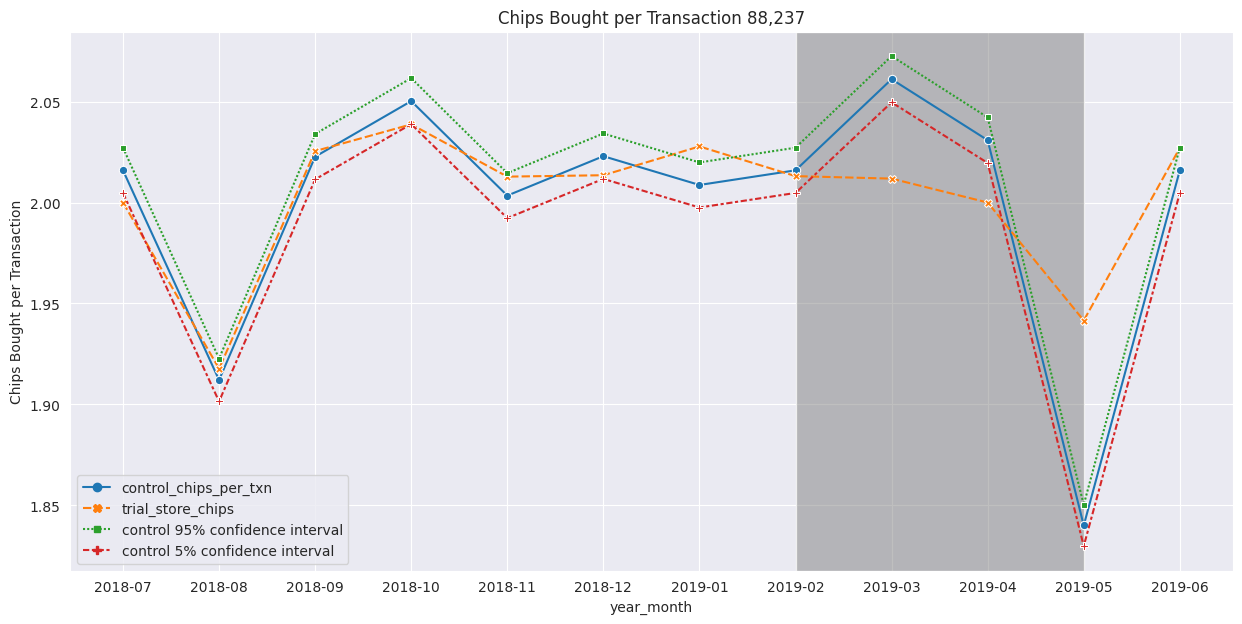

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(chips_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Chips Bought per Transaction')
plt.title('Chips Bought per Transaction 88,237')
plt.show()

**Average Price per Chip Unit bought**

In [ ]:
scaling_factor_price = df3[df3['store_type'] == 'trial store']['avg_price_per_unit'].sum()/\
                    df3[df3['store_type'] == 'control store']['avg_price_per_unit'].sum()
scaling_factor_price

calc_tvalues(88,237,'avg_price_per_unit',scaling_factor_price)

degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

price_over_time = merged_price[['year_month','control_avg_price_per_unit','trial_store_price']]
price_over_time['control 95% confidence interval'] = price_over_time ['control_avg_price_per_unit'] * (1 + std_dev_price * 2)
price_over_time['control 5% confidence interval'] = price_over_time ['control_avg_price_per_unit'] * (1 - std_dev_price * 2)
price_over_time.set_index('year_month',inplace=True)

plt.figure(figsize=(15,7))
sns.lineplot(price_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Average Price per Chip Unit')
plt.title('Average Price per Chip Unit 88,237')
plt.show()

In [ ]:
scaling_factor_price = df3[df3['store_type'] == 'trial store']['avg_price_per_unit'].sum()/\
                    df3[df3['store_type'] == 'control store']['avg_price_per_unit'].sum()
scaling_factor_price


0.9894148932668695

In [ ]:
calc_tvalues(88,237,'avg_price_per_unit',scaling_factor_price)

,year_month,t_value
7,2019-02,0.403549
8,2019-03,0.334391
9,2019-04,1.117775


In [ ]:
degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

T-critical value: 1.9431802803927816


In [ ]:
merged_price.head(3)

,year_month,control_avg_price_per_unit,trial_store_price,perc_diff,t_value
0,2018-07,4.423051,4.281046,0.032106,2.586591
1,2018-08,4.323711,4.368977,0.010469,0.843442
2,2018-09,4.375265,4.474843,0.022759,1.833586


In [ ]:
price_over_time = merged_price[['year_month','control_avg_price_per_unit','trial_store_price']]
price_over_time['control 95% confidence interval'] = price_over_time ['control_avg_price_per_unit'] * (1 + std_dev_price * 2)
price_over_time['control 5% confidence interval'] = price_over_time ['control_avg_price_per_unit'] * (1 - std_dev_price * 2)
price_over_time.set_index('year_month',inplace=True)

In [ ]:
price_over_time

,control_avg_price_per_unit,trial_store_price,control 95% confidence interval,control 5% confidence interval
year_month,,,,
2018-07,4.423051,4.281046,4.532852,4.313250
2018-08,4.323711,4.368977,4.431046,4.216376
2018-09,4.375265,4.474843,4.483880,4.266651
2018-10,4.461632,4.279747,4.572391,4.350874
2018-11,4.321270,4.403822,4.428544,4.213995
2018-12,4.330830,4.446980,4.438342,4.223318
2019-01,4.356640,4.336986,4.464793,4.248488
2019-02,4.426529,4.448701,4.536416,4.316641
2019-03,4.362814,4.344706,4.471120,4.254508


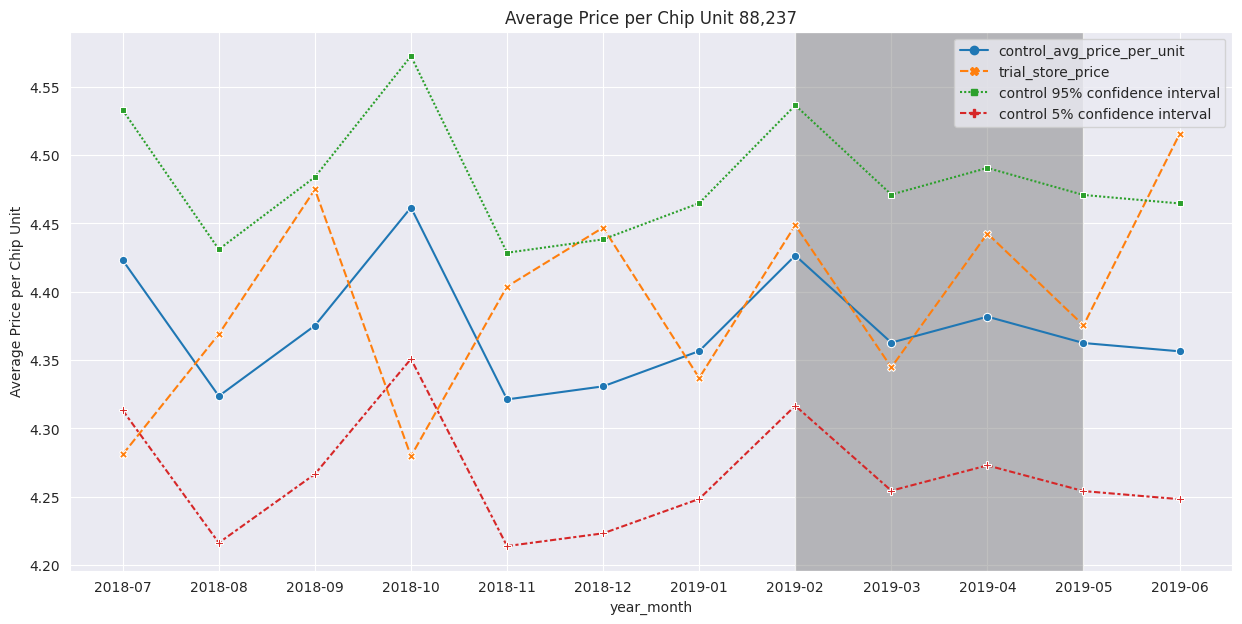

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(price_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Average Price per Chip Unit')
plt.title('Average Price per Chip Unit 88,237')
plt.show()

In [ ]:
scaling_factor_chips = df3[df3['store_type'] == 'trial store']['txn_per_cust'].sum()/\
                    df3[df3['store_type'] == 'control store']['txn_per_cust'].sum()
scaling_factor_chips

calc_tvalues(88,237,'txn_per_cust',scaling_factor_txn)

degrees_of_freedom = 6

t_critical = t.ppf(0.95, df=degrees_of_freedom)
print(f'T-critical value: {t_critical}')

transactions_over_time = merged_transactions[['year_month','control_txn_per_cust','trial_store_transactions']]
transactions_over_time['control 95% confidence interval'] = transactions_over_time ['control_txn_per_cust'] * (1 + std_dev_transactions * 2)
transactions_over_time['control 5% confidence interval'] = transactions_over_time ['control_txn_per_cust'] * (1 - std_dev_transactions * 2)
transactions_over_time.set_index('year_month',inplace=True)

plt.figure(figsize=(15,7))
sns.lineplot(transactions_over_time,markers=True)
plt.axvspan('2019-02','2019-05', facecolor='grey', alpha=0.5)
plt.ylabel('Monthly_Transactions_per_customer')
plt.title('Monthly_Transactions_per_customer 88,237')
plt.show()

**Conclusion**

- Control stores 233, 155, 237  were found for the trial stores 77, 86 and 88
respectively.
- Generally, the trial was successful as an increased was observed in both monthly sales and number of unique customers across majority of the trial period.
- A significant increase was observed in trial store 86 in number of unique customers throughout the entirity of the trial period. It could be worth looking into this.
- Store 88 showed an increase in both Monthly Sales and Monthly Number of unique customers throughout the trial period.
- An increase in number of transactions per customer was also observed during the months of March and April.